In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

from dataloaders import Dataloader, MnistSpikesDataloader
from spiking import iterate_spikes
from spiking.layers import IntegrateAndFireLayer, IntegrateAndFireMultilayer, SpikingSequential
from spiking.learning import STDP
from spiking.competition import WinnerTakesAll

from visualization import SpikesVisualization

In [3]:
dataloader = MnistSpikesDataloader("./data/mnist-subset", 'train')
validation_dataloader = MnistSpikesDataloader("./data/mnist-subset", 'test')
max_x, max_y = dataloader.inputs[0].shape
max_z = 2
max_input_spikes = max_x * max_y * max_z
print(f"{max_input_spikes = }")

max_input_spikes = 1568


In [33]:
def train(model: IntegrateAndFireMultilayer, num_epochs: int = 12, plot_rate: int = 4):
    for epoch_idx in tqdm.trange(1, num_epochs + 1):
        for batch_idx, (spikes, label, times) in enumerate(dataloader.iterate(batch_size=1), start=1):
            membrane_potentials = []
            membrane_potentials_times = []
            
            for incoming_spikes, current_time, dt in iterate_spikes(spikes, shape=(max_x, max_y, max_z)):
                output_spike = model.forward(incoming_spikes.flatten(), current_time=current_time, dt=dt)
                
                if np.any(output_spike == 1.0):
                    membrane_potentials.append([
                        neuron.threshold if output_spike[neuron_idx] else neuron.membrane_potential
                        for neuron_idx, neuron in enumerate(model.layers[-1].neurons)
                    ])
                    membrane_potentials_times.append(current_time)
                membrane_potentials.append([neuron.membrane_potential for neuron in model.layers[-1].neurons])
                membrane_potentials_times.append(current_time)
            
            pre_spike_times = times.flatten()
            model.backward(pre_spike_times)
            post_spike_times = model.spike_times
    
            if epoch_idx % plot_rate == 0 and batch_idx <= 3:
                SpikesVisualization.plot_pre_post_spikes(
                    pre_spike_times,
                    post_spike_times,
                    title=f"Pre-synaptic vs Post-synaptic. Epoch {epoch_idx} - Batch {batch_idx} - Label {label}",
                    unique_colors=True
                )
                SpikesVisualization.plot_multiple_membrane_potentials(
                    membrane_potentials,
                    membrane_potentials_times,
                    title=f"Membrane Potential Over Time. Epoch {epoch_idx} - Batch {batch_idx} - Label {label}"
                )
            
            model.reset()

def dataloader_to_spike_times(model: IntegrateAndFireMultilayer, arg_dataloader: Dataloader):
    X, y = [], []
    for batch_idx, (spikes, label, _) in enumerate(arg_dataloader.iterate(batch_size=1), start=1):
        for incoming_spikes, current_time, dt in iterate_spikes(spikes, shape=(max_x, max_y, max_z)):
            model.forward(incoming_spikes.flatten(), current_time=current_time, dt=dt)
        X.append(np.clip(1.2 - model.spike_times, 0, 1.2))
        y.append(label)
        model.reset()
    return np.array(X), np.array(y)

def eval_snn(model: IntegrateAndFireMultilayer):
    X_train, y_train = dataloader_to_spike_times(model, dataloader)
    X_test, y_test = dataloader_to_spike_times(model, validation_dataloader)
    print(f"{X_train.shape = }, {y_train.shape = }")
    print(f"{X_test.shape = }, {y_test.shape = }")

    classifier = LinearSVC()
    classifier.fit(X_train, y_train)
    
    print("Train accuracy:", accuracy_score(y_train, classifier.predict(X_train)))
    
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_train)
    
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, cmap='viridis', edgecolor='k', alpha=0.7)
    plt.colorbar(scatter, label='Class Label')
    plt.title("Train Data Visualized with PCA")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.grid()
    plt.show()
    
    y_pred = classifier.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print("Confusion Matrix:")
    print(conf_matrix)

def visualize_neurons_weights(model: IntegrateAndFireMultilayer, layer: int, num_neurons: int):
    for i in range(num_neurons):
        img = model.layers[layer].neurons[i].weights.reshape((max_z, max_x, max_y))
        plt.title(f"Weights {i}")
        plt.axis("off")
        plt.subplot(1, 2, 1)
        plt.imshow(img[0, :, :], cmap='grey')
        plt.axis("off")
        plt.subplot(1, 2, 2)
        plt.imshow(img[1, :, :], cmap='grey')
        plt.axis("off")
        plt.show()

In [12]:
stdp = STDP()
wta = WinnerTakesAll()

In [16]:
model1 = IntegrateAndFireMultilayer(
    num_inputs=max_input_spikes, num_hidden=[24], num_outputs=8, learning_mechanism=stdp, competition_mechanism=wta, threshold=1.0, refractory_period=np.inf
)

 10%|█         | 1/10 [00:14<02:14, 14.92s/it]

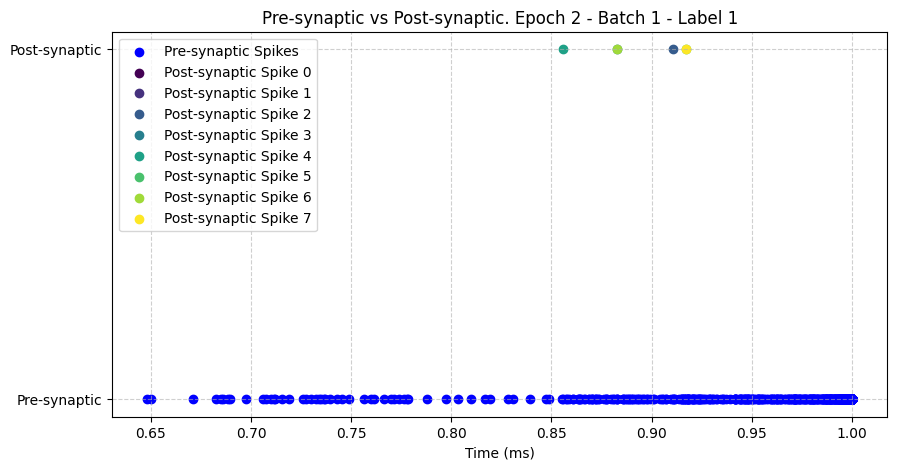

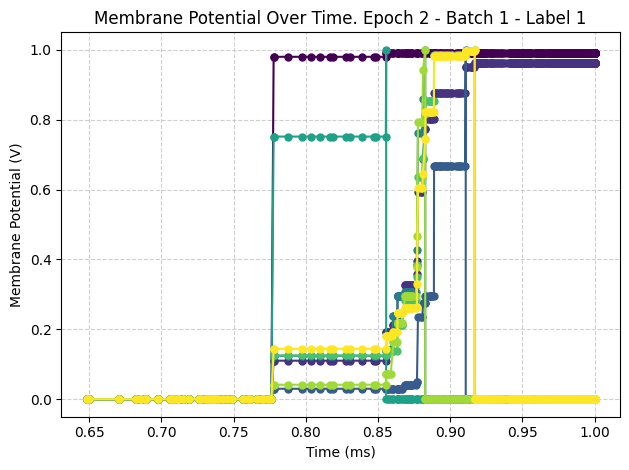

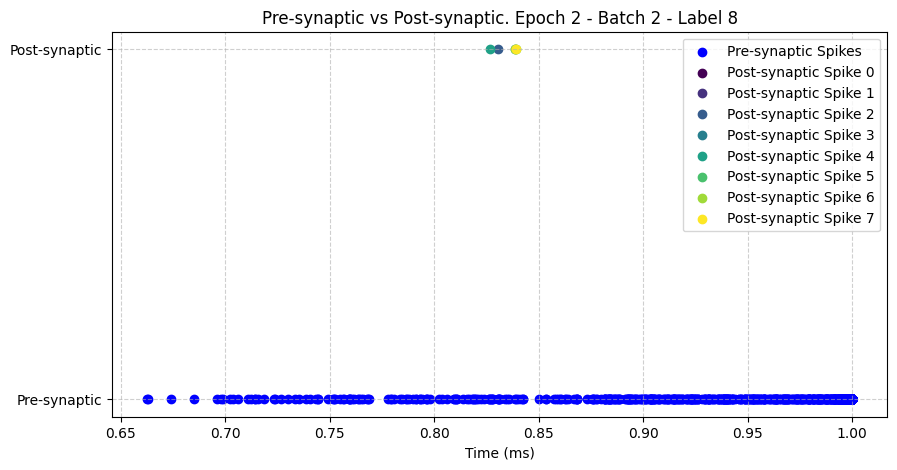

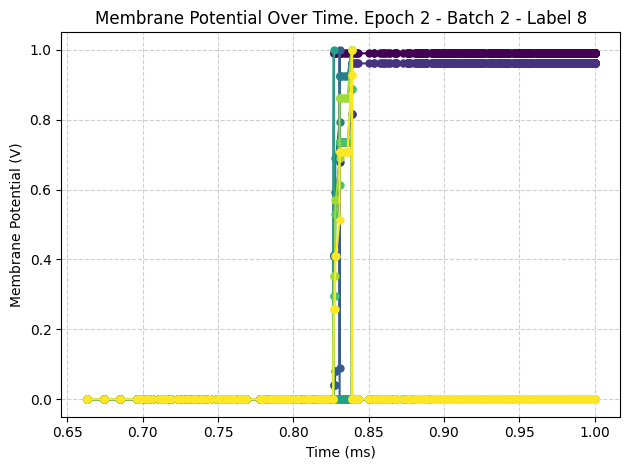

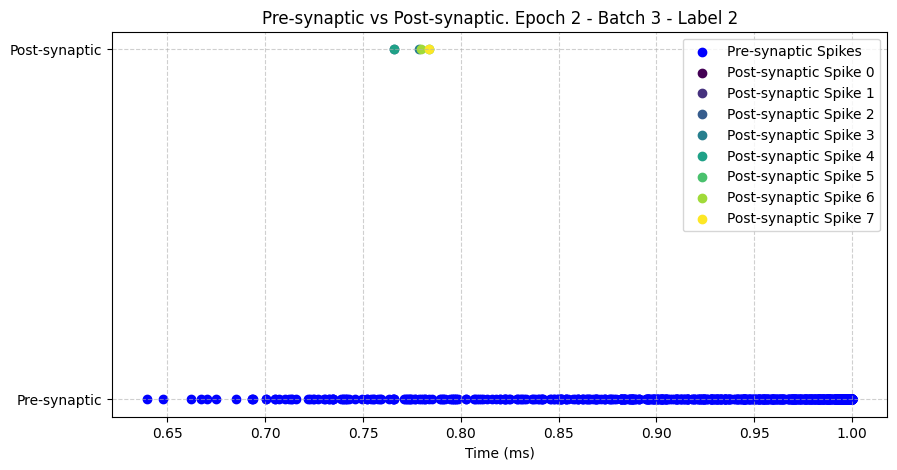

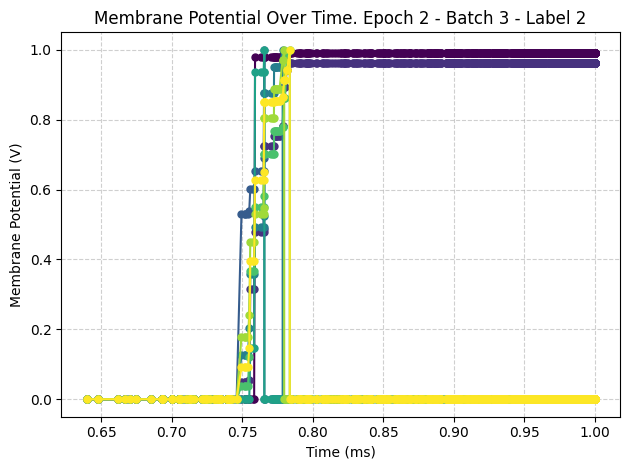

 30%|███       | 3/10 [00:48<01:53, 16.28s/it]

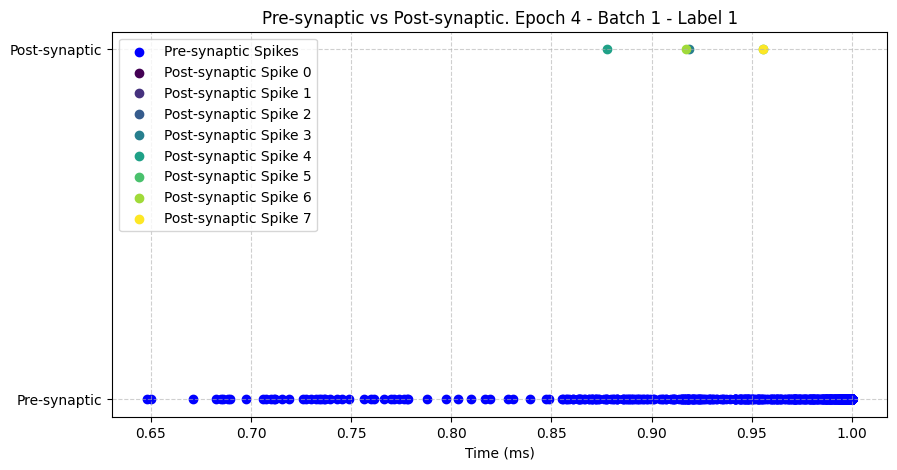

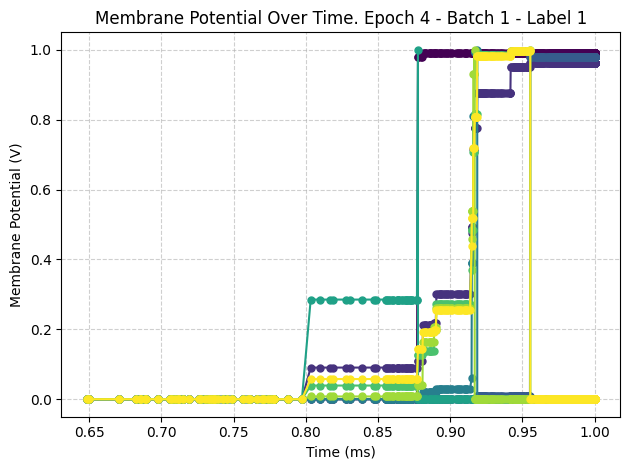

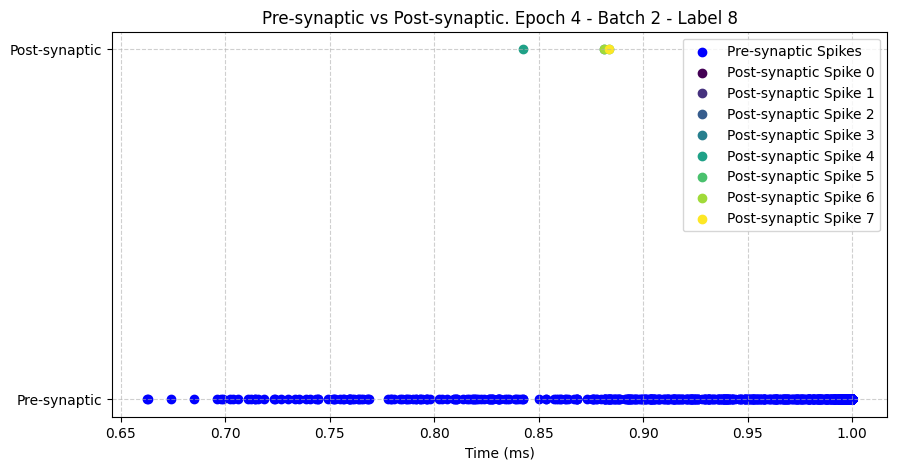

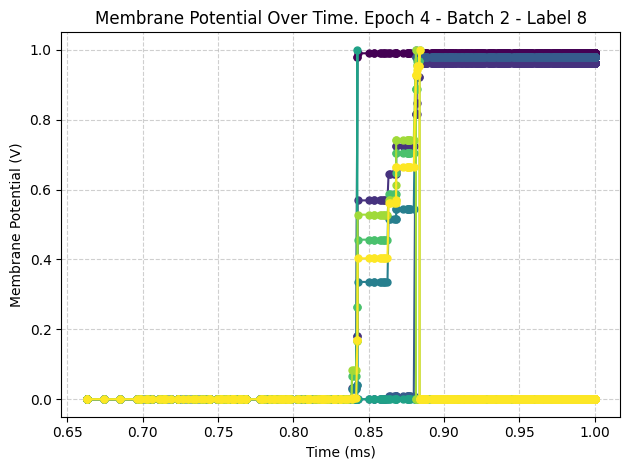

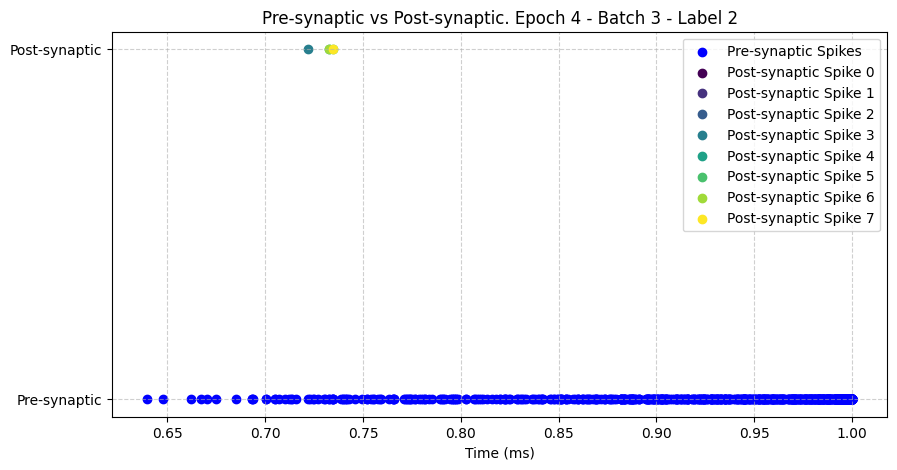

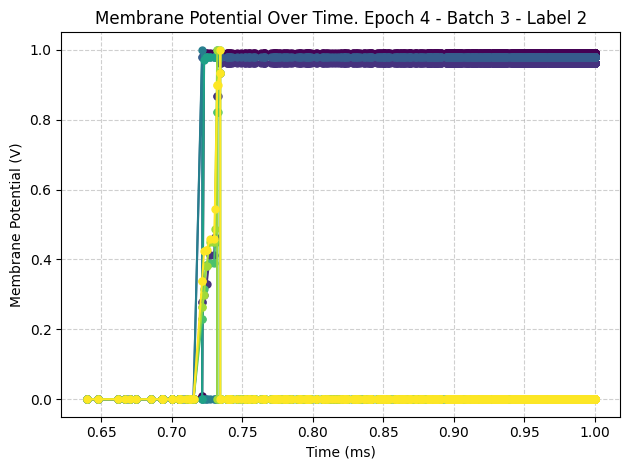

 50%|█████     | 5/10 [01:23<01:26, 17.21s/it]

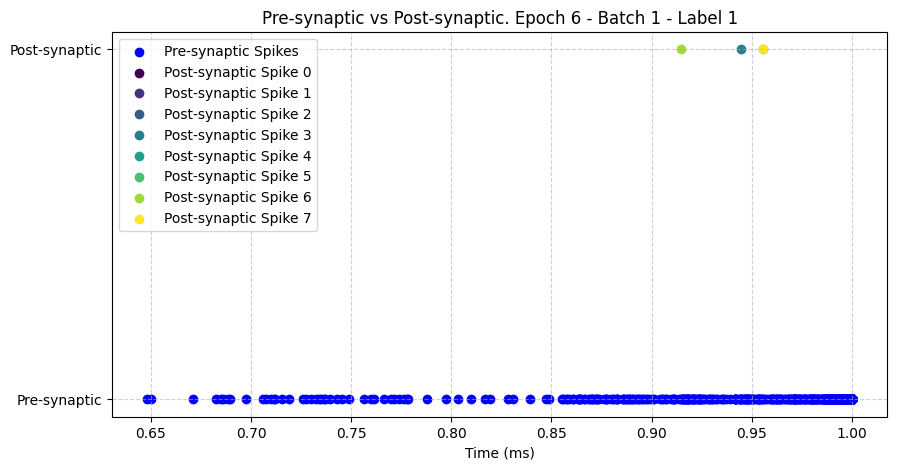

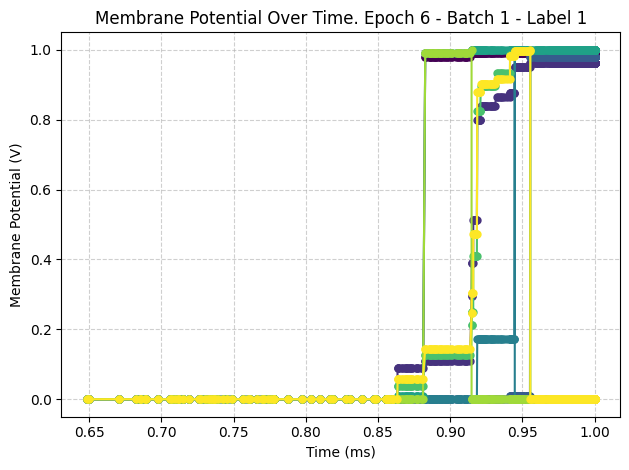

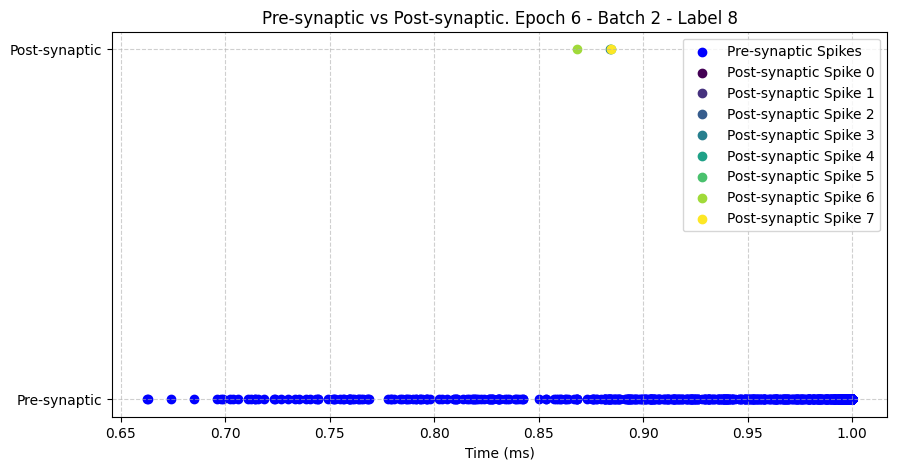

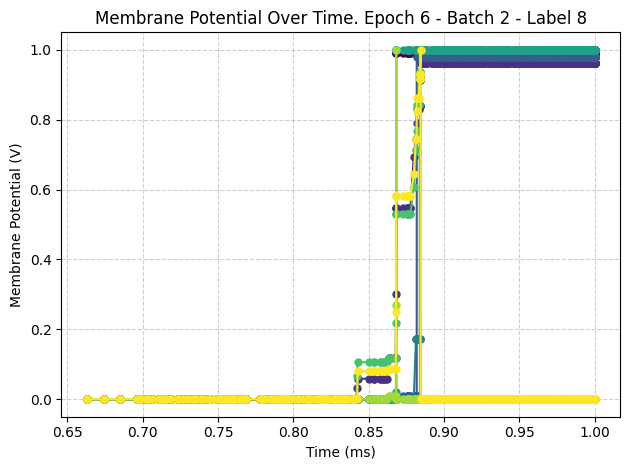

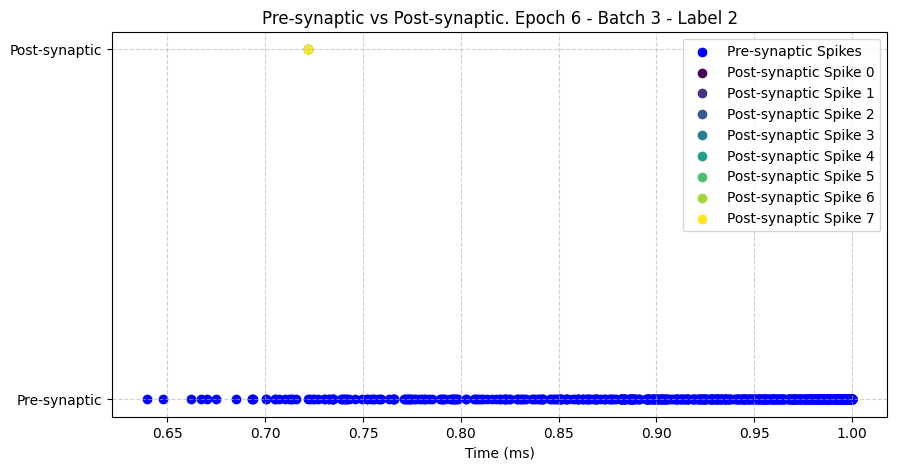

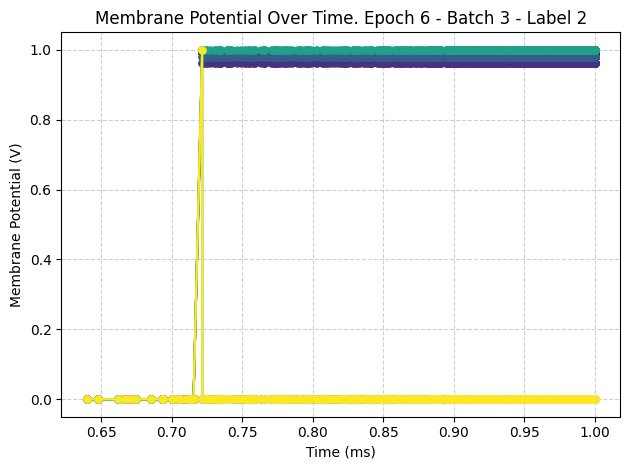

 70%|███████   | 7/10 [02:01<00:54, 18.17s/it]

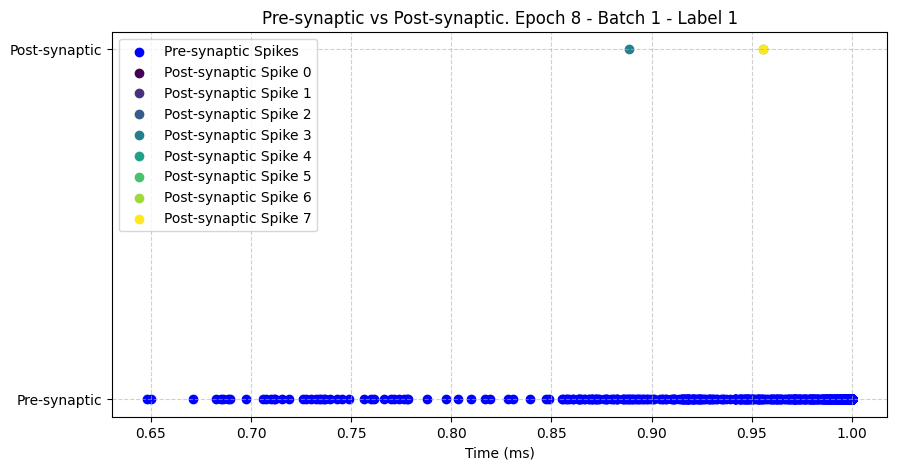

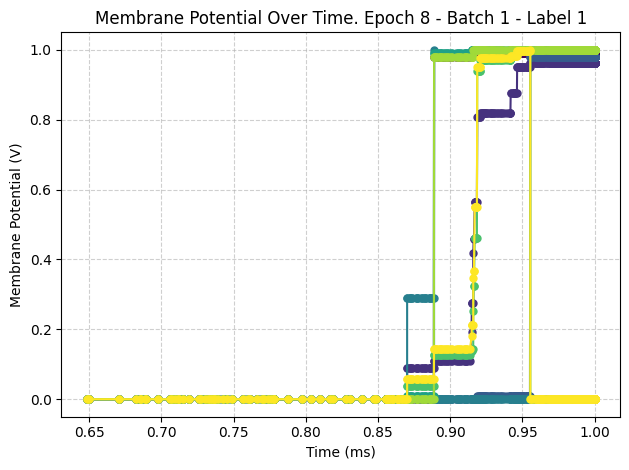

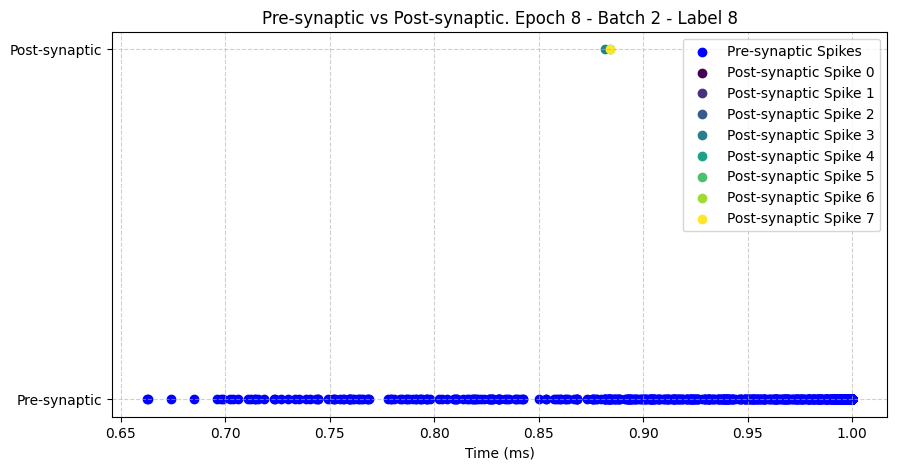

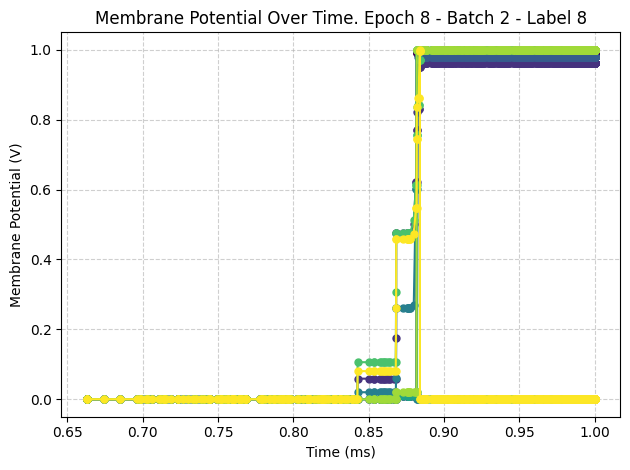

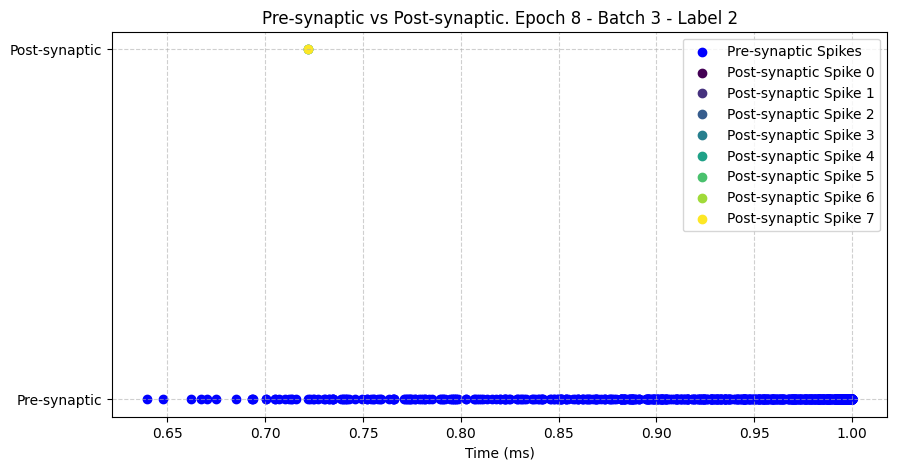

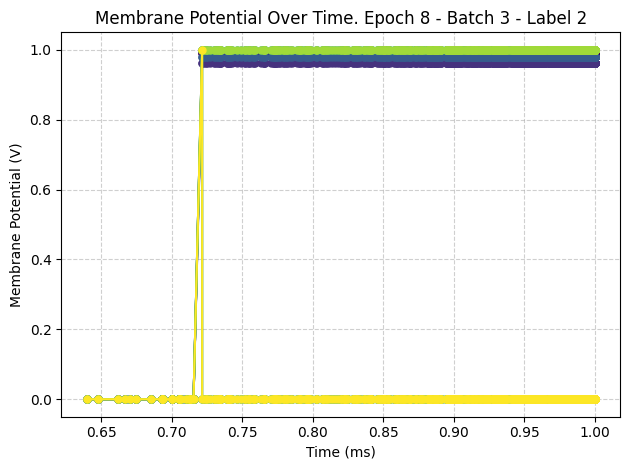

 90%|█████████ | 9/10 [02:39<00:18, 18.63s/it]

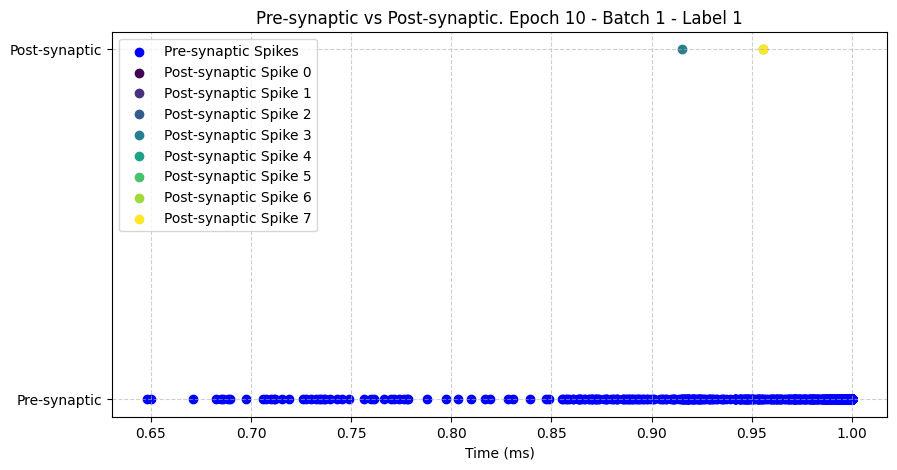

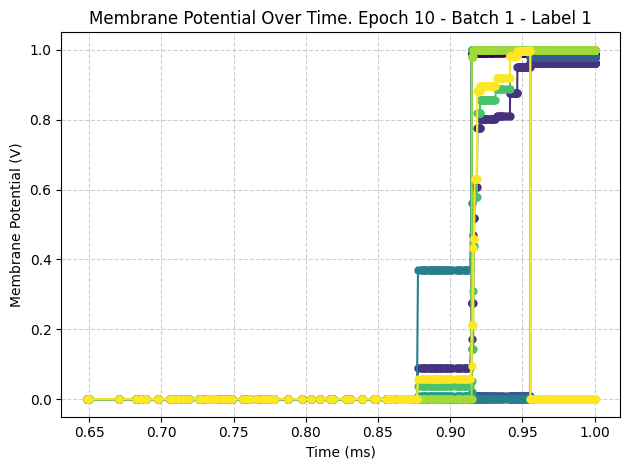

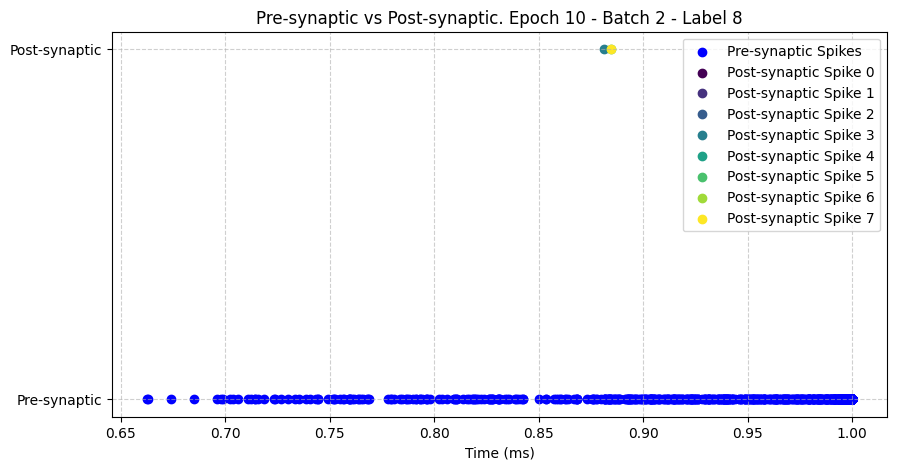

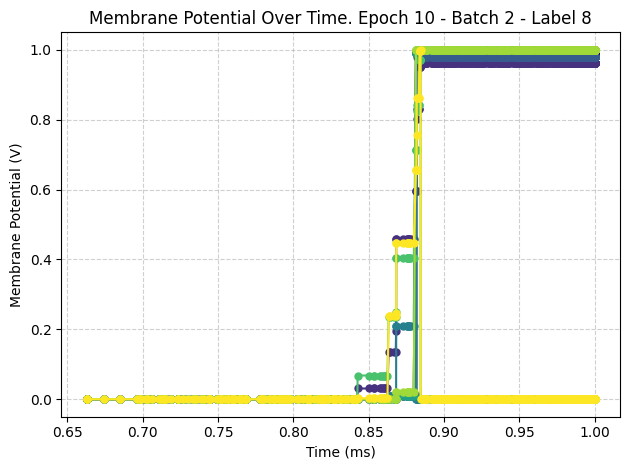

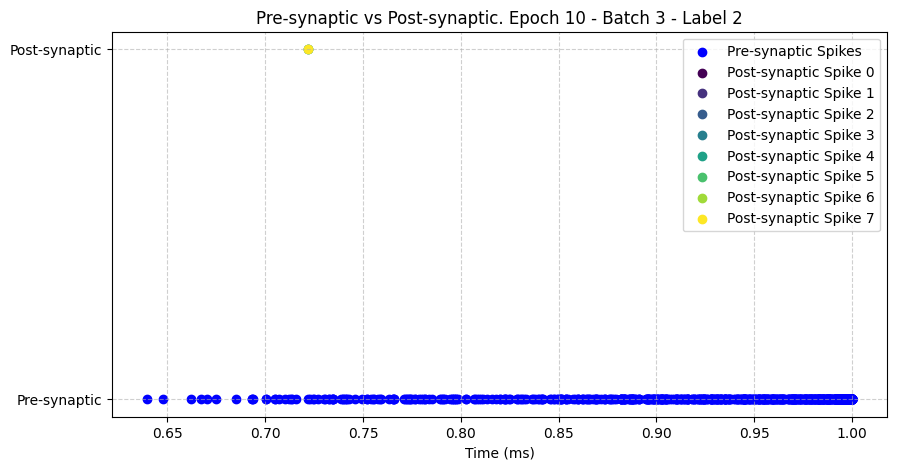

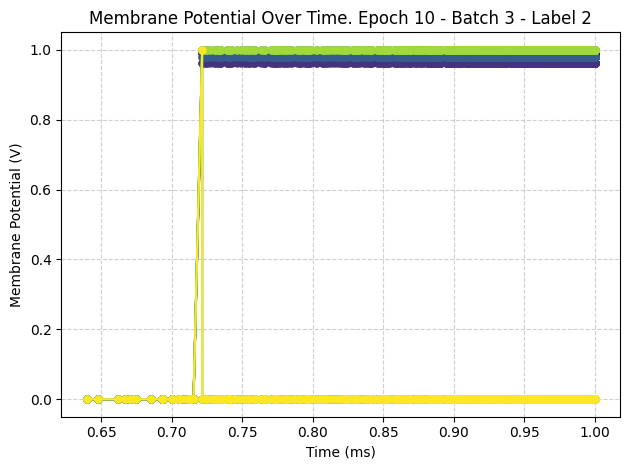

100%|██████████| 10/10 [02:59<00:00, 17.94s/it]


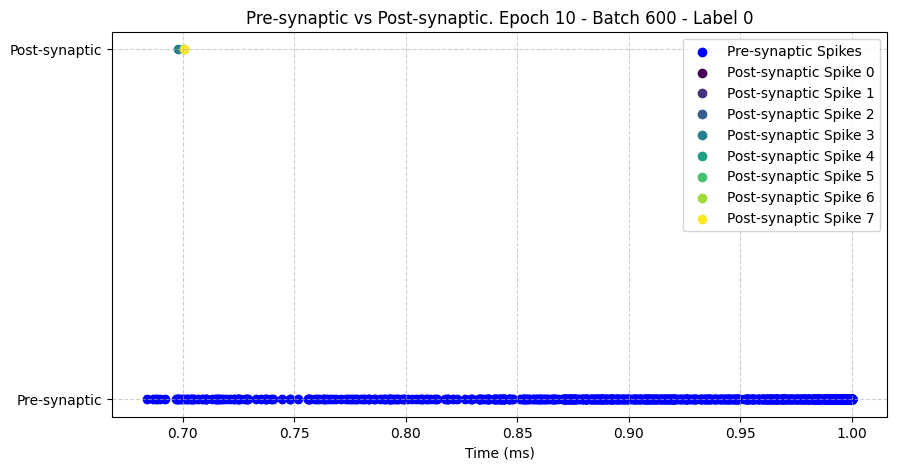

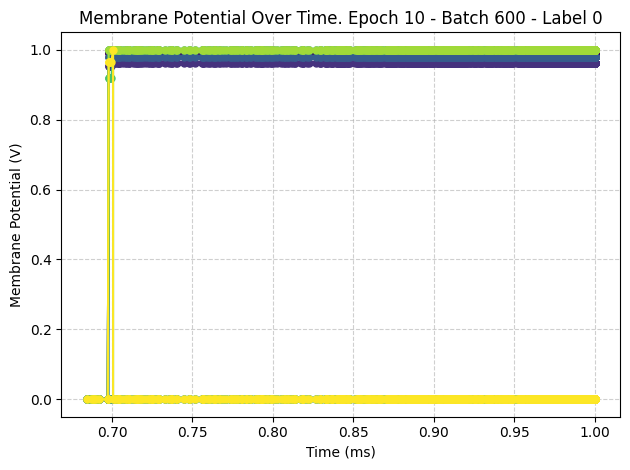

In [17]:
train(model1, num_epochs=10)

In [19]:
model2 = IntegrateAndFireMultilayer(
    num_inputs=max_input_spikes, num_hidden=[24], num_outputs=8, learning_mechanism=stdp, competition_mechanism=wta, threshold=1.0, refractory_period=np.inf
)

  8%|▊         | 1/12 [00:13<02:29, 13.62s/it]

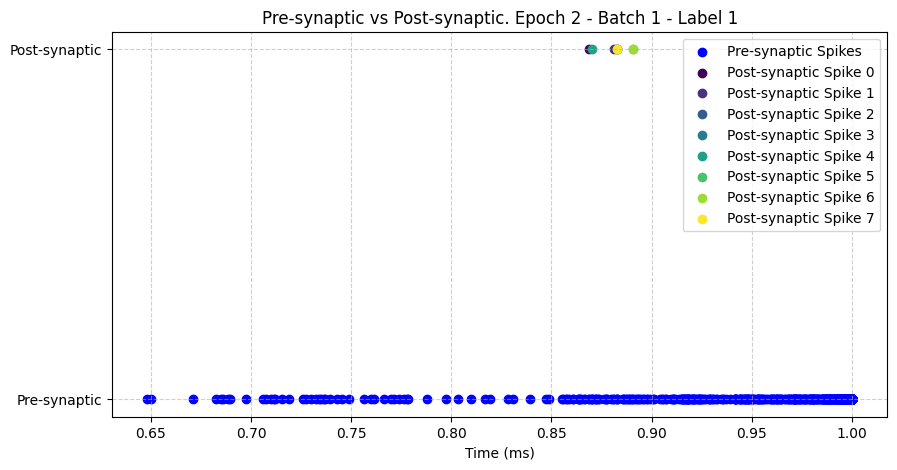

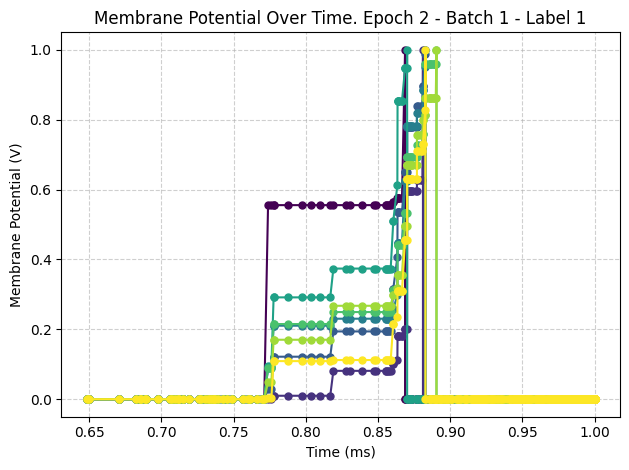

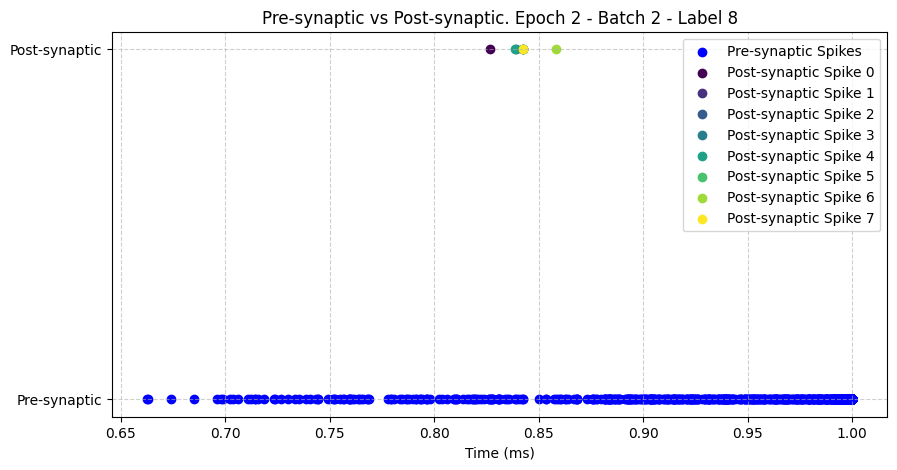

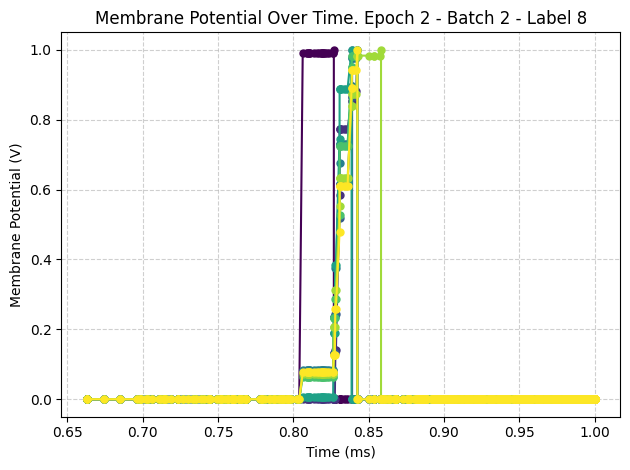

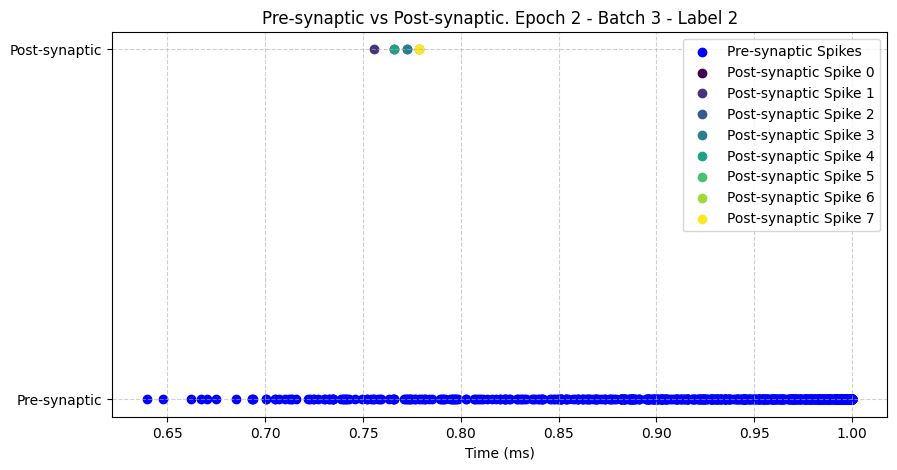

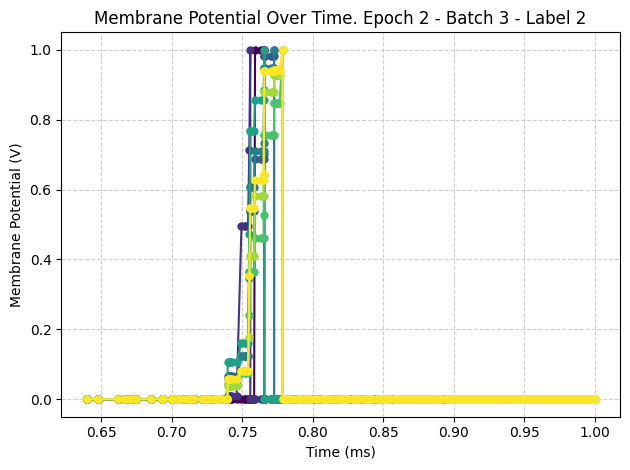

 25%|██▌       | 3/12 [00:43<02:13, 14.80s/it]

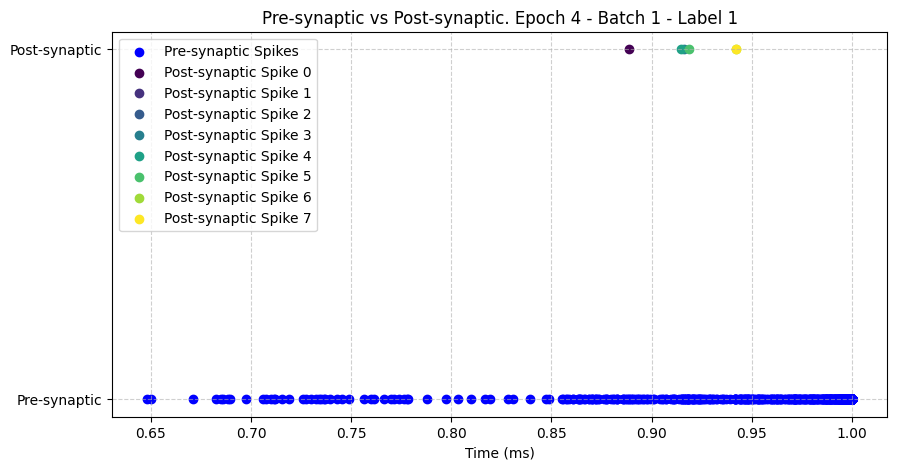

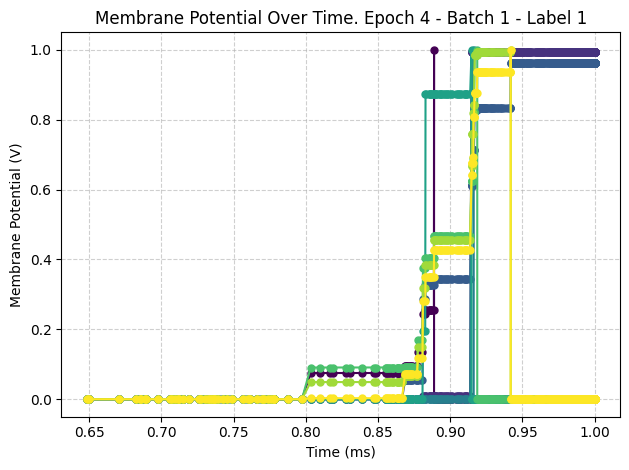

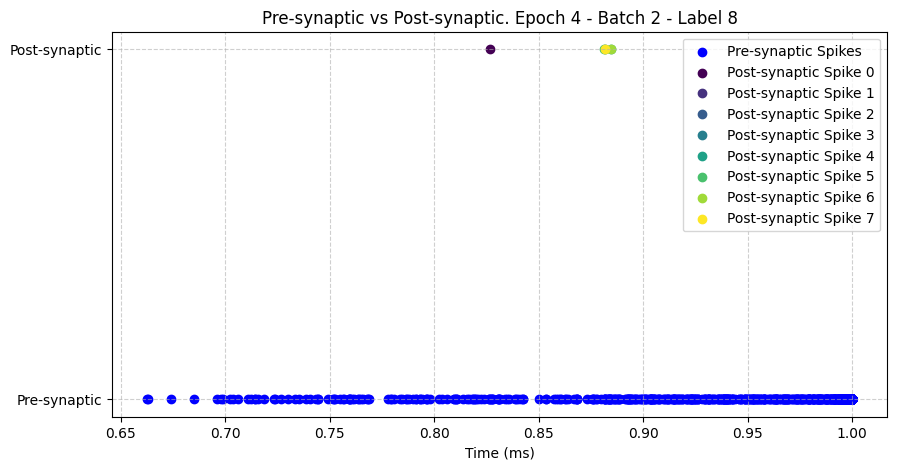

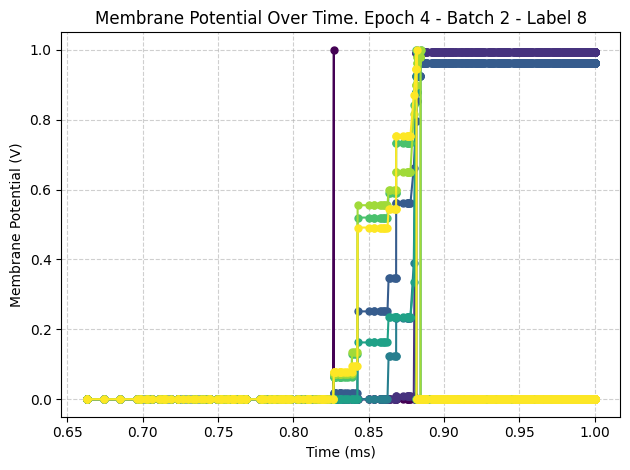

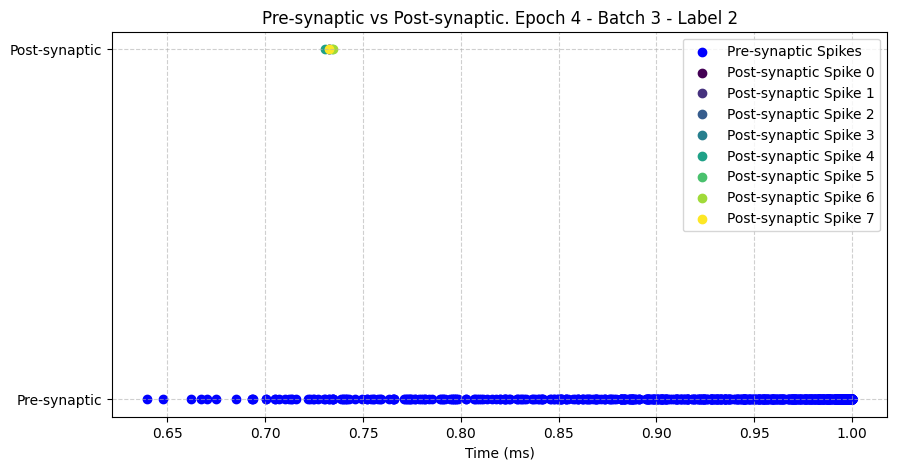

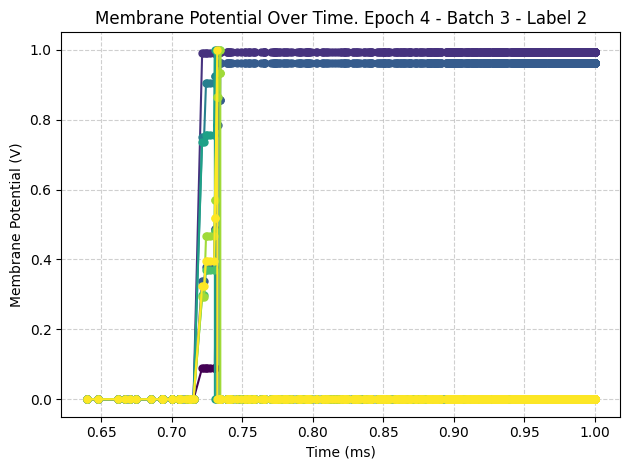

 42%|████▏     | 5/12 [01:18<01:54, 16.30s/it]

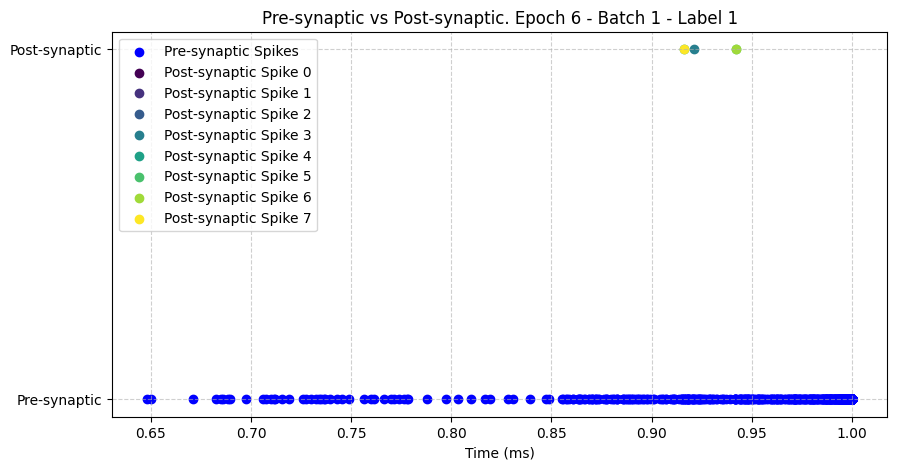

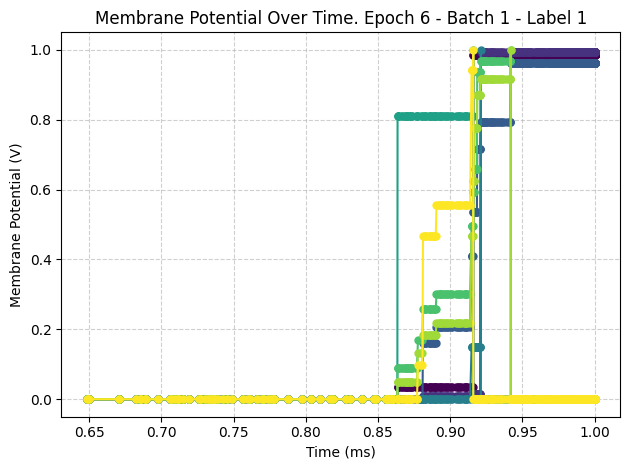

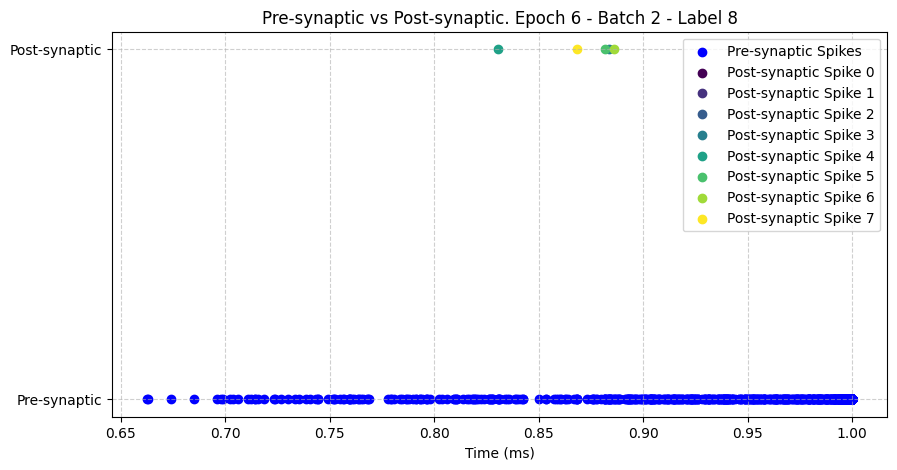

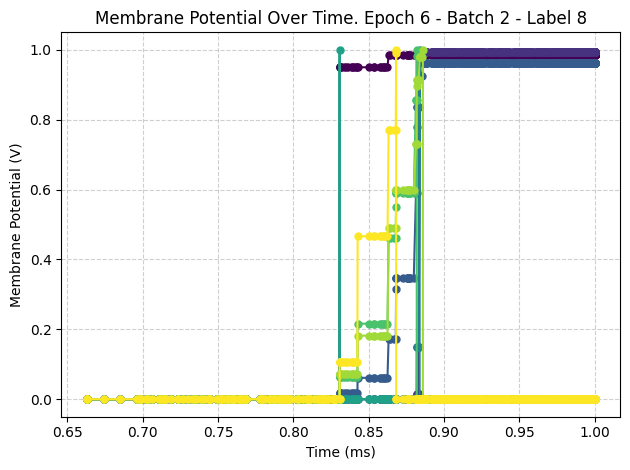

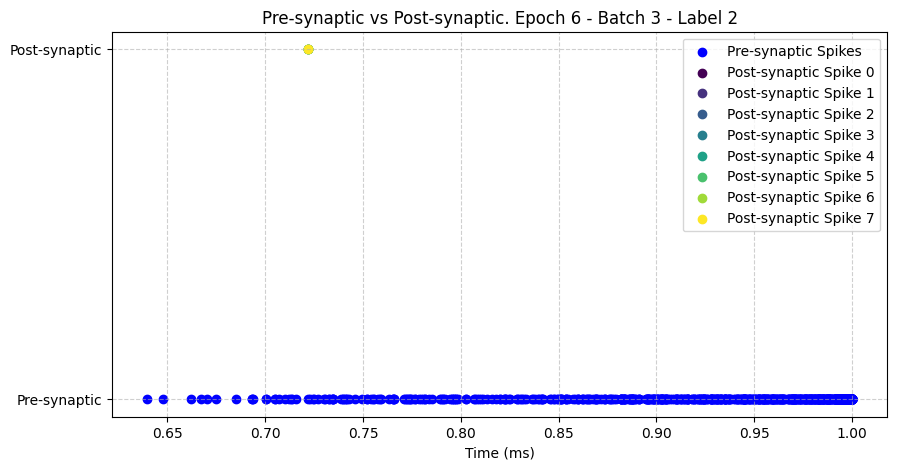

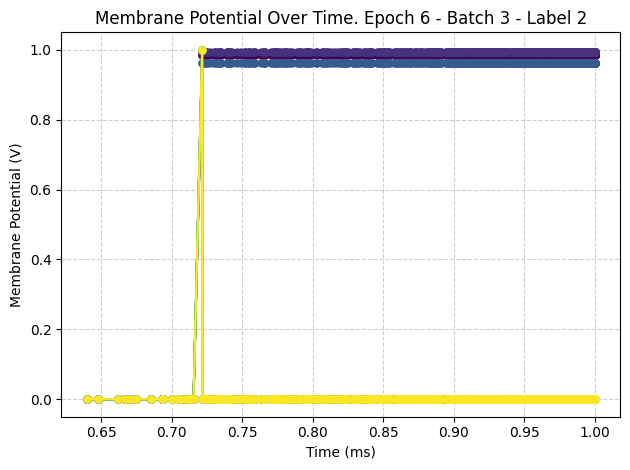

 58%|█████▊    | 7/12 [01:54<01:26, 17.36s/it]

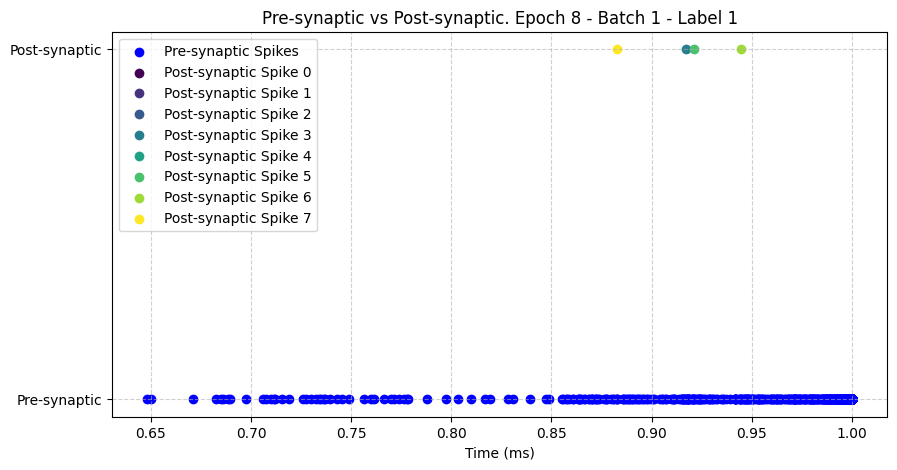

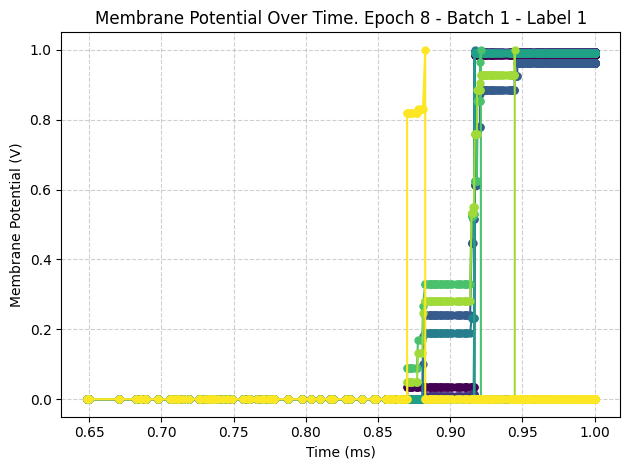

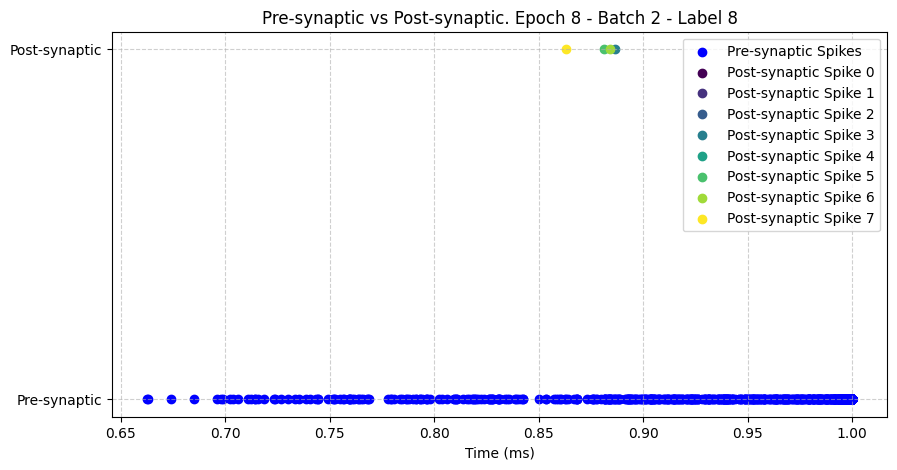

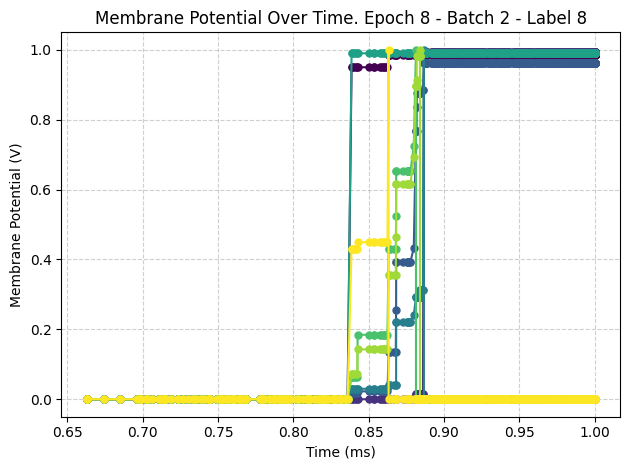

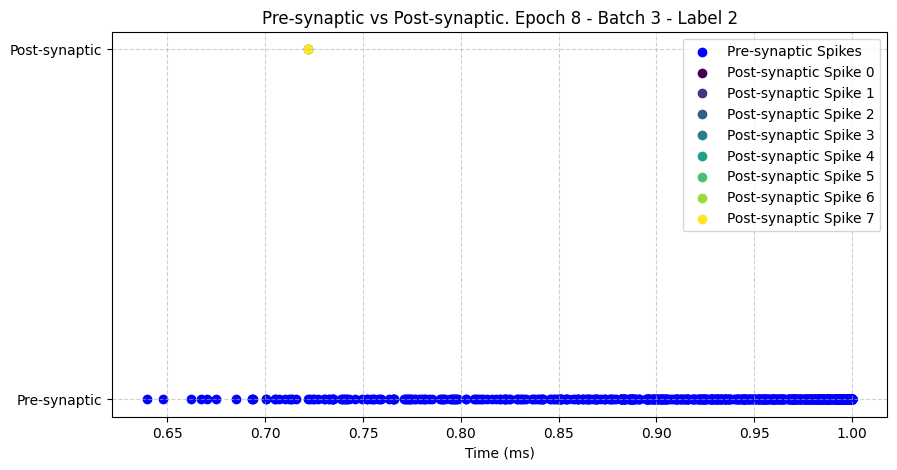

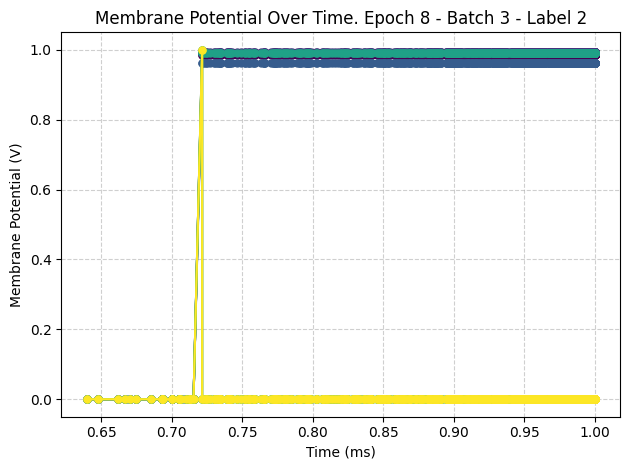

 75%|███████▌  | 9/12 [02:32<00:54, 18.12s/it]

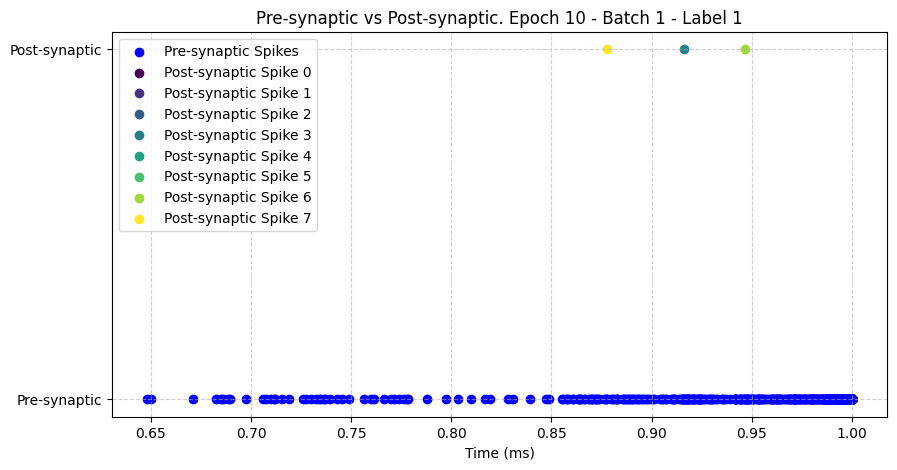

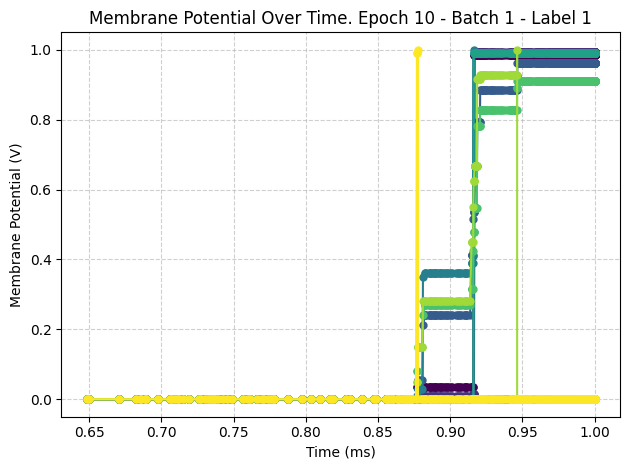

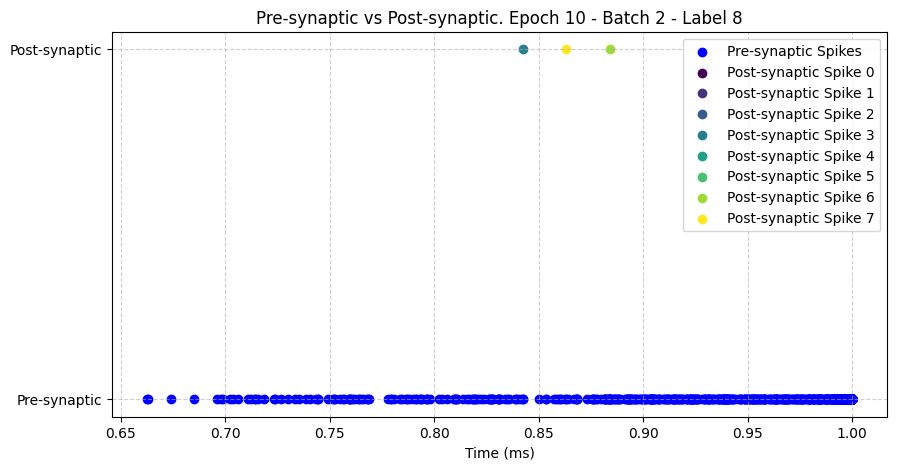

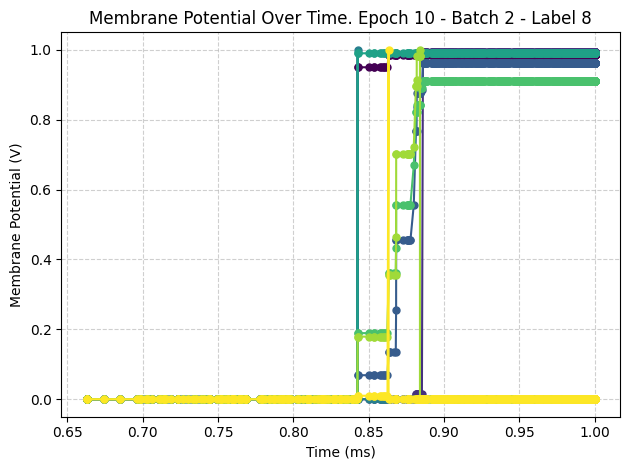

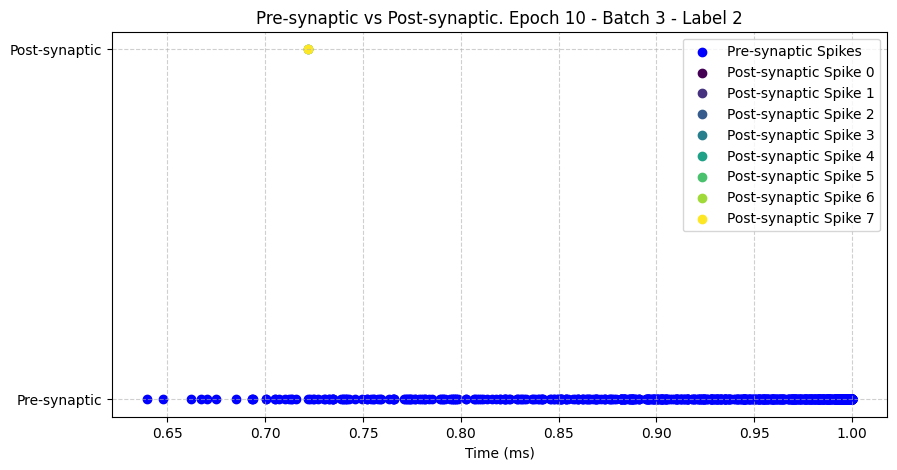

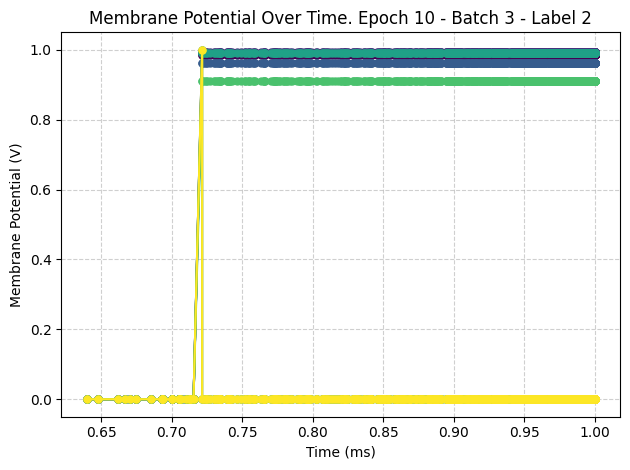

 92%|█████████▏| 11/12 [03:13<00:19, 19.37s/it]

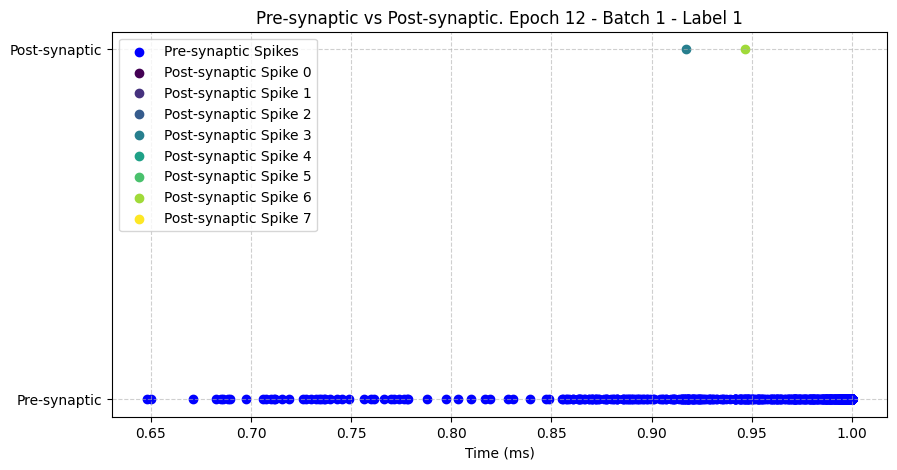

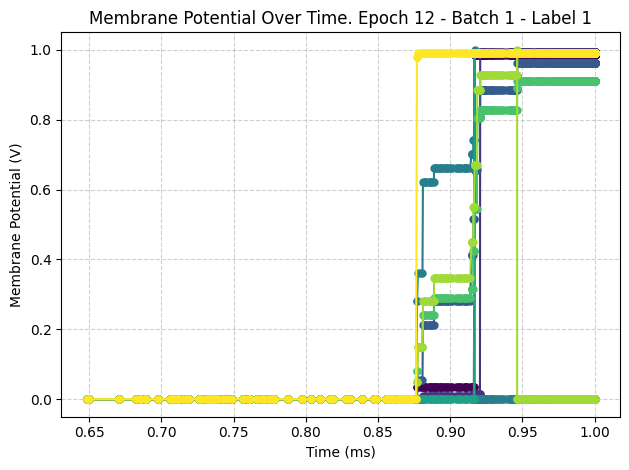

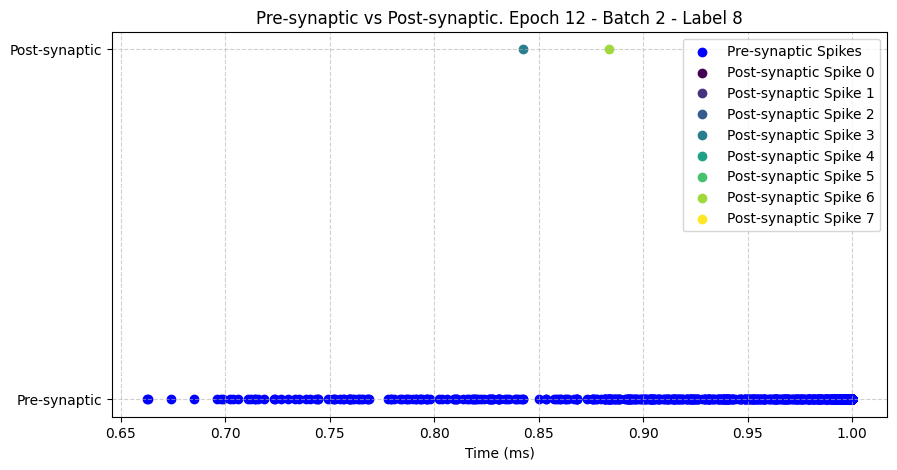

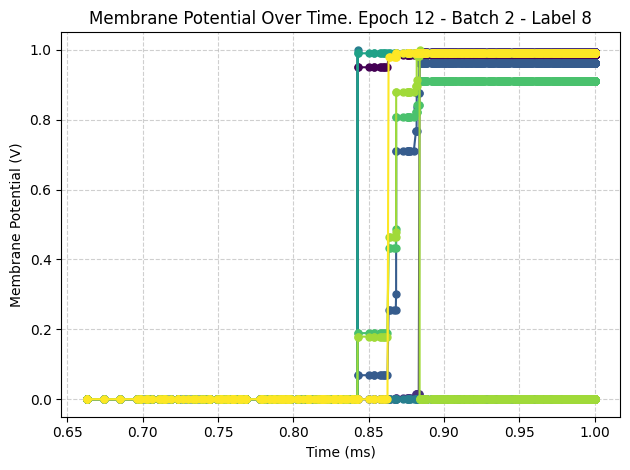

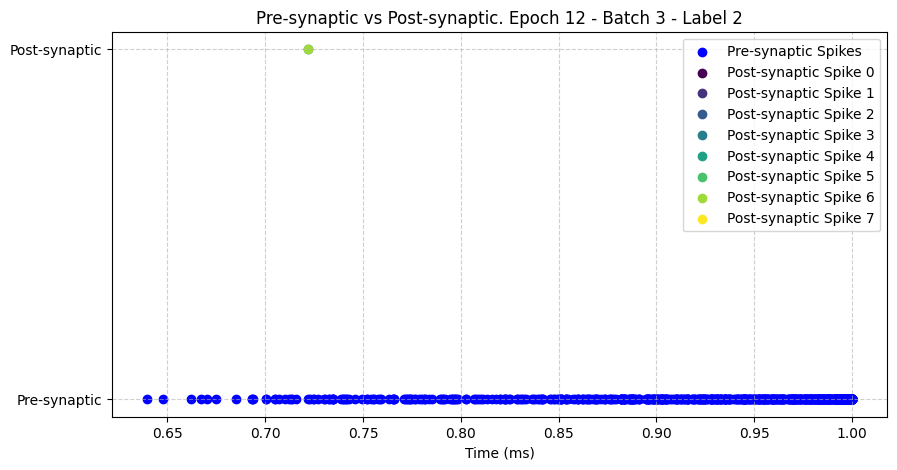

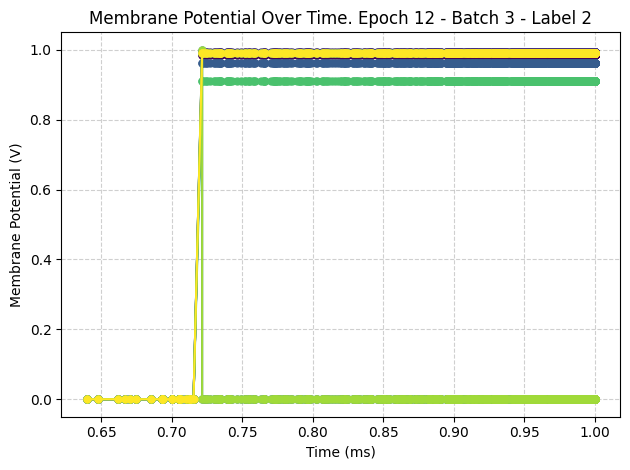

100%|██████████| 12/12 [03:34<00:00, 17.89s/it]


In [20]:
train(model2, num_epochs=12)

[[1.5        1.5        1.5        ... 1.5        0.9447282  1.5       ]
 [1.5        1.5        1.5        ... 1.5        0.8840758  1.5       ]
 [1.5        1.5        1.5        ... 1.5        0.73239344 1.5       ]
 ...
 [1.5        1.5        1.5        ... 1.5        0.827193   1.5       ]
 [1.5        1.5        1.5        ... 1.5        0.7826825  1.5       ]
 [1.5        1.5        1.5        ... 1.5        0.7249963  1.5       ]] [[1.5        1.5        1.5        0.8887481  1.5        1.5
  0.9052978  1.5       ]
 [1.5        1.5        1.5        0.76623243 1.5        1.5
  0.776929   1.5       ]
 [1.5        1.5        1.5        0.85602677 1.5        1.5
  0.8960948  1.5       ]
 [1.5        1.5        1.5        0.81933045 1.5        1.5
  0.85972595 1.5       ]
 [1.5        1.5        1.5        0.76741314 1.5        1.5
  0.8144172  1.5       ]
 [1.5        1.5        1.5        0.87232125 1.5        1.5
  0.87232125 1.5       ]
 [1.5        1.5        1.5        0.905

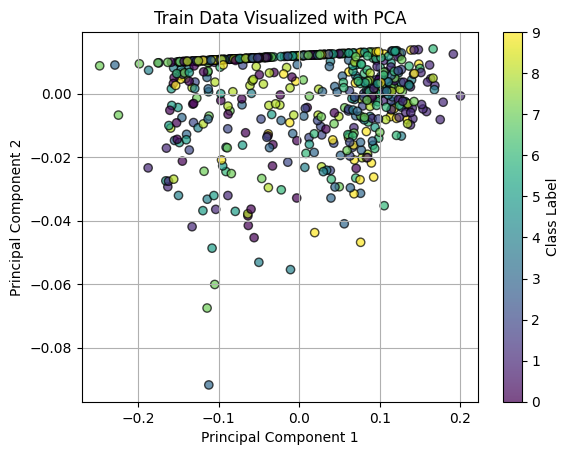

Accuracy: 0.18
Precision: 0.04
Recall: 0.18
F1 Score: 0.06
Confusion Matrix:
[[ 8  1  0  0  0  0  1  0  0  0]
 [ 0 10  0  0  0  0  0  0  0  0]
 [ 4  5  0  1  0  0  0  0  0  0]
 [ 5  5  0  0  0  0  0  0  0  0]
 [ 3  7  0  0  0  0  0  0  0  0]
 [ 6  4  0  0  0  0  0  0  0  0]
 [ 2  8  0  0  0  0  0  0  0  0]
 [ 6  3  0  0  0  0  1  0  0  0]
 [ 7  1  0  1  0  0  1  0  0  0]
 [ 2  8  0  0  0  0  0  0  0  0]]


/Users/Razvan/Uni/dummy-snn/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [21]:
eval_snn(model2)

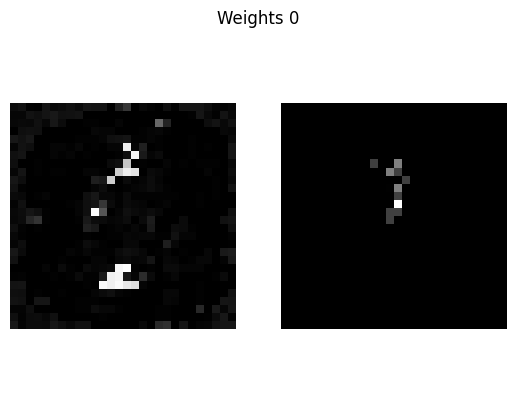

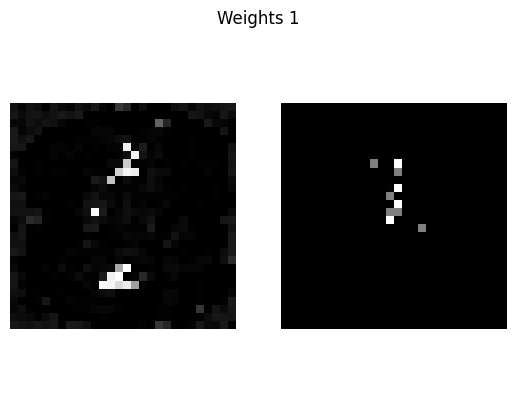

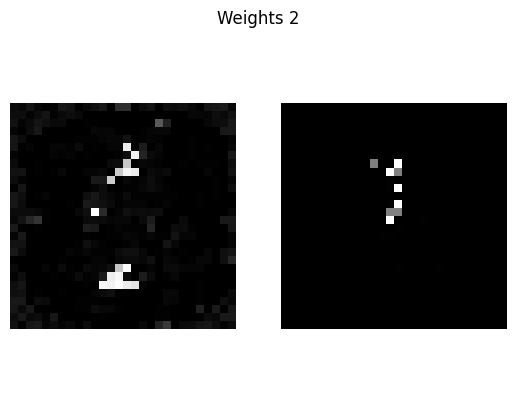

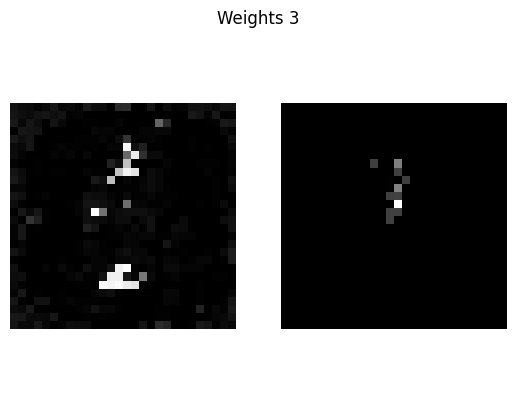

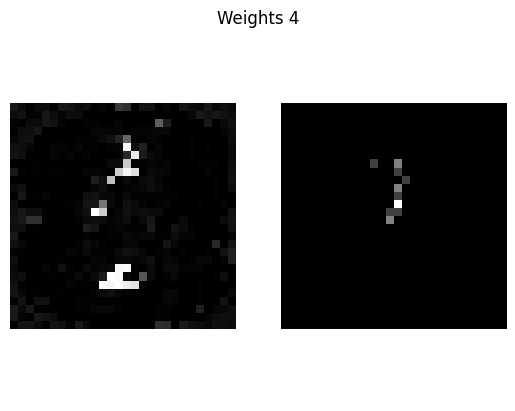

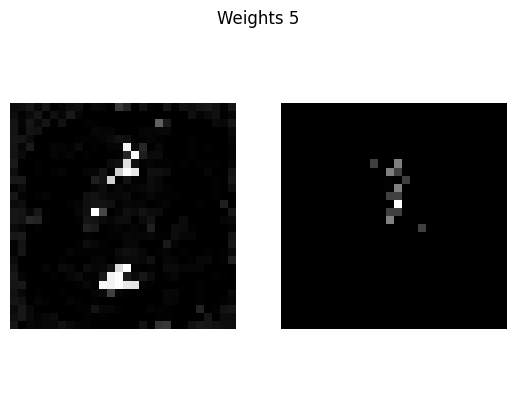

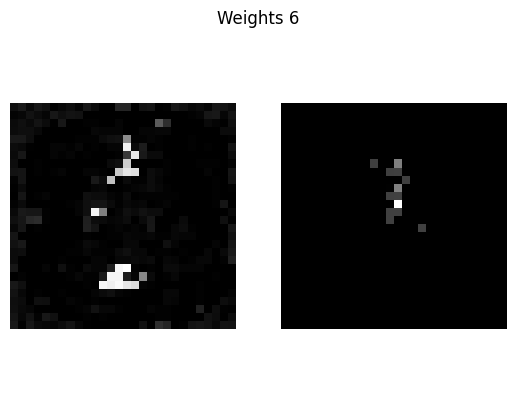

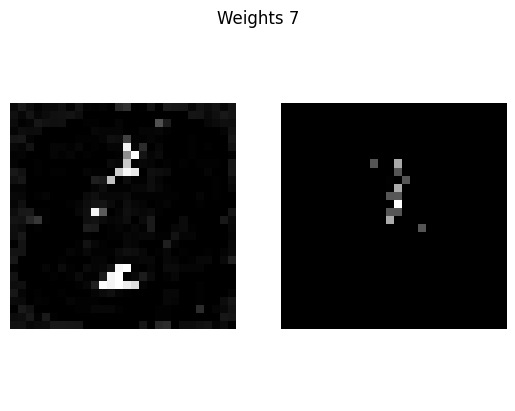

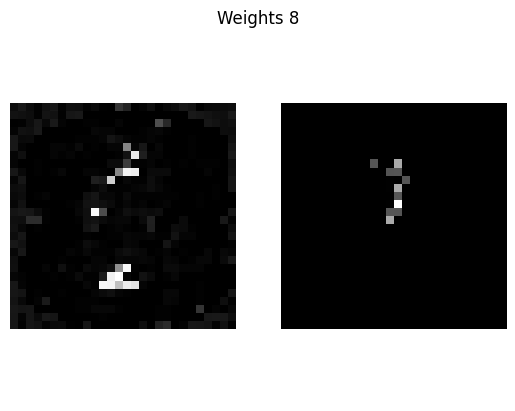

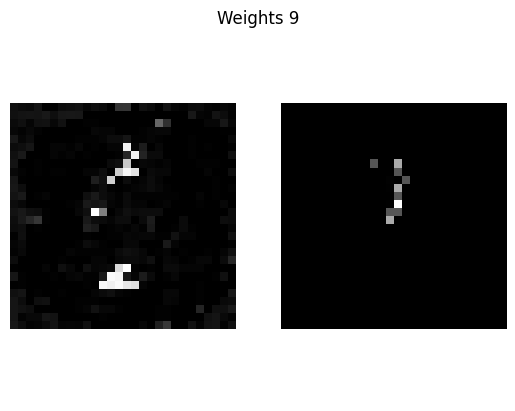

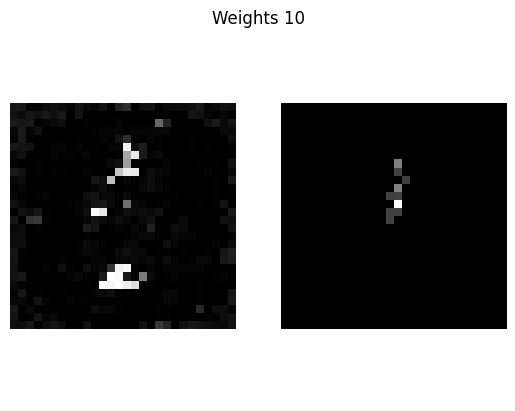

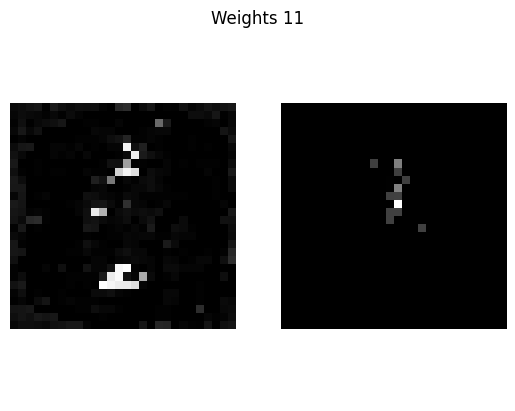

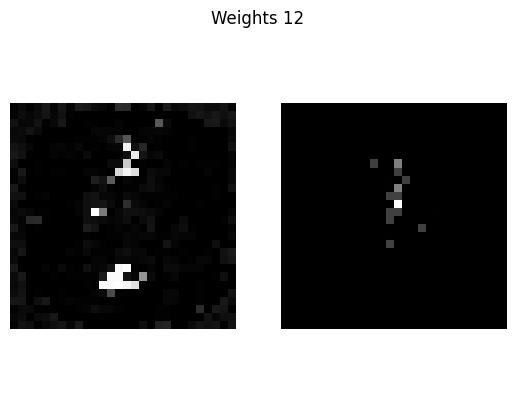

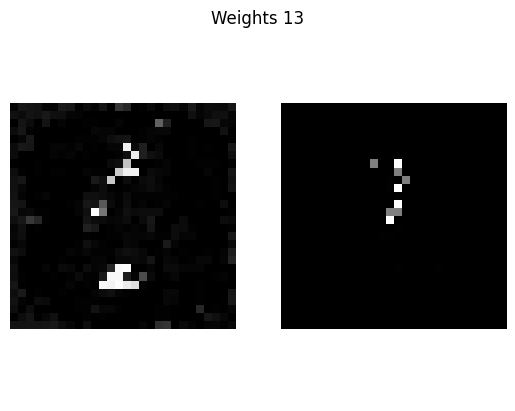

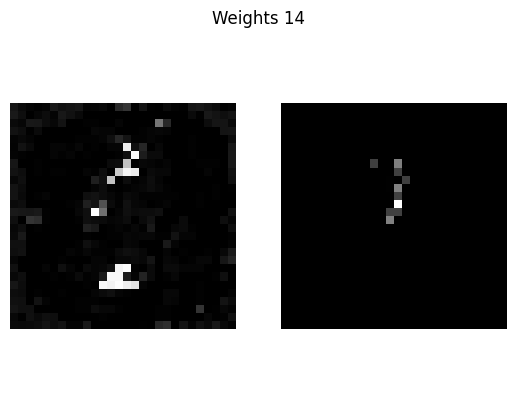

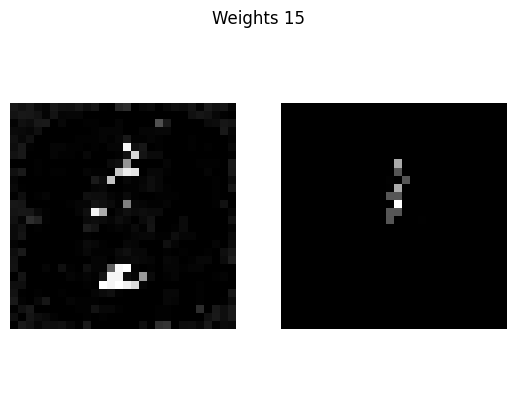

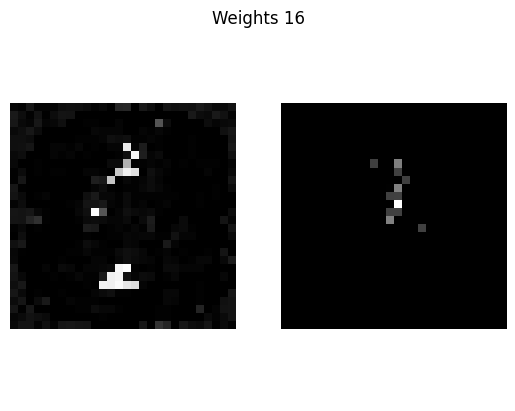

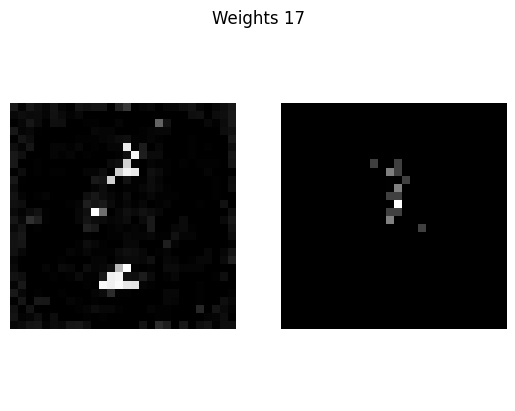

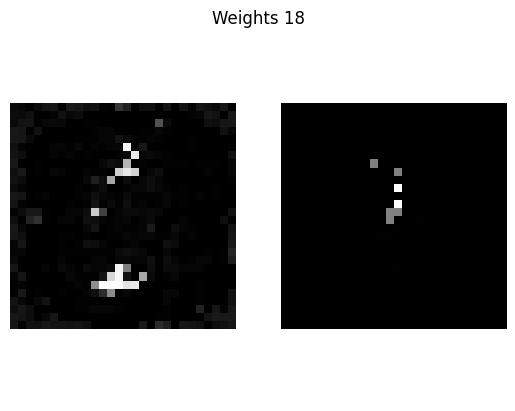

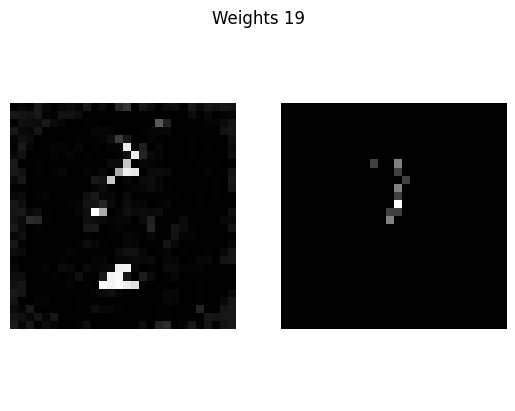

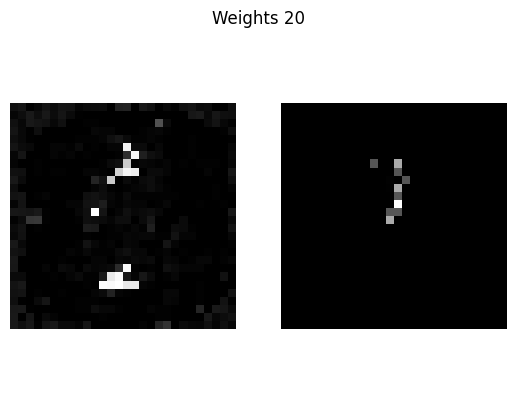

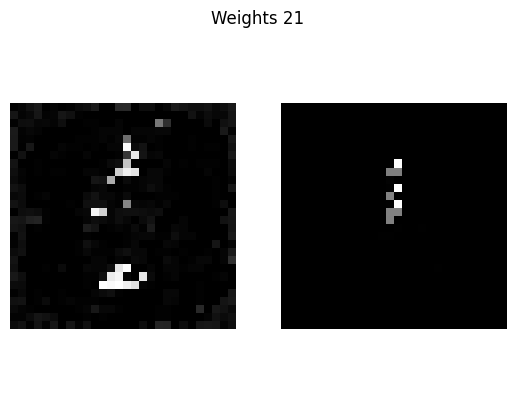

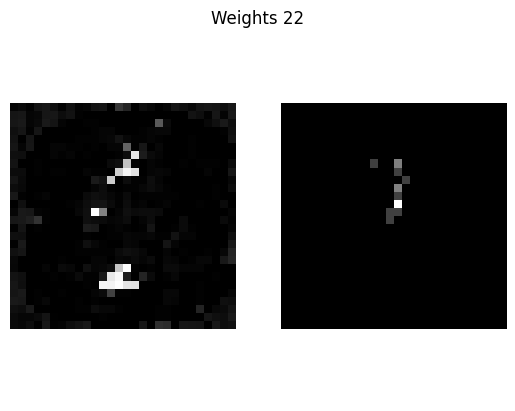

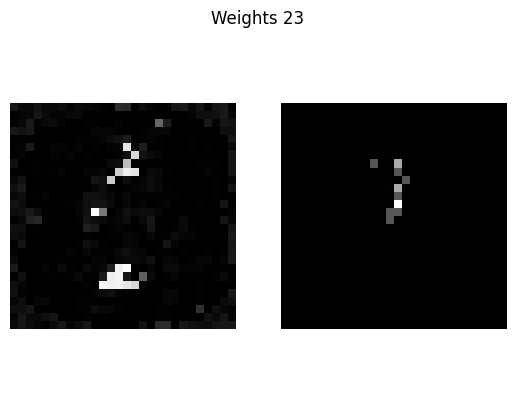

In [22]:
visualize_neurons_weights(model2, 0, 24)

In [23]:
model3 = SpikingSequential(
    IntegrateAndFireLayer(num_inputs=max_input_spikes, num_outputs=24, learning_mechanism=stdp, competition_mechanism=wta, threshold=1.0, refractory_period=np.inf),
    IntegrateAndFireLayer(num_inputs=24, num_outputs=8, learning_mechanism=stdp, competition_mechanism=wta, threshold=0.8, refractory_period=np.inf),
)

 25%|██▌       | 3/12 [00:50<02:34, 17.13s/it]

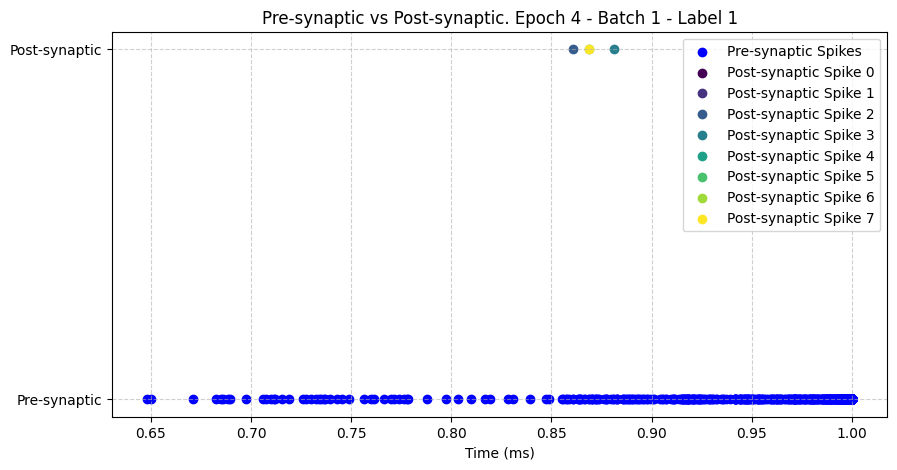

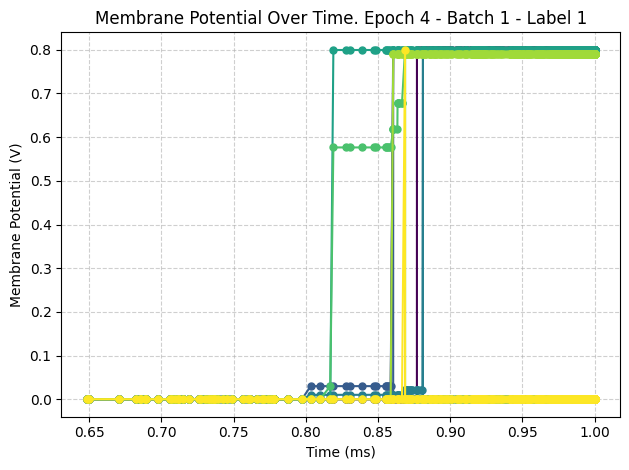

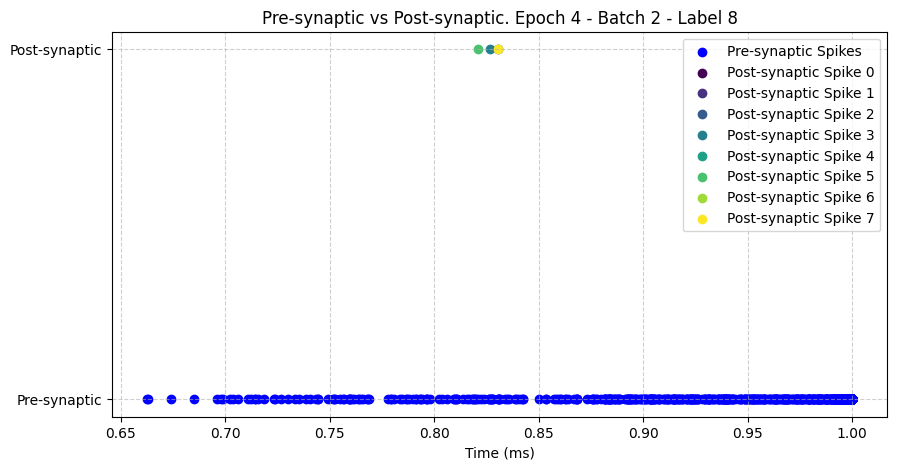

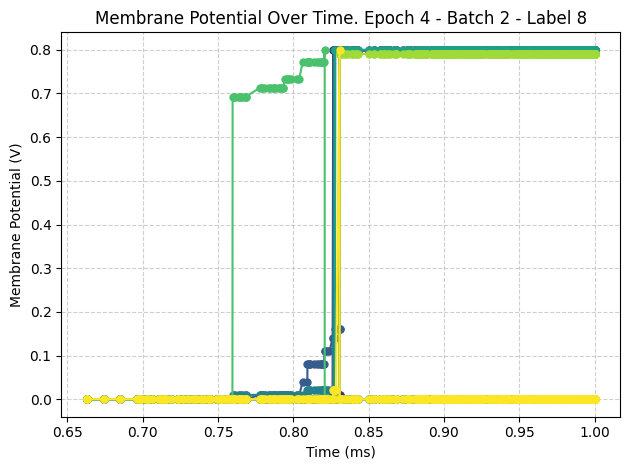

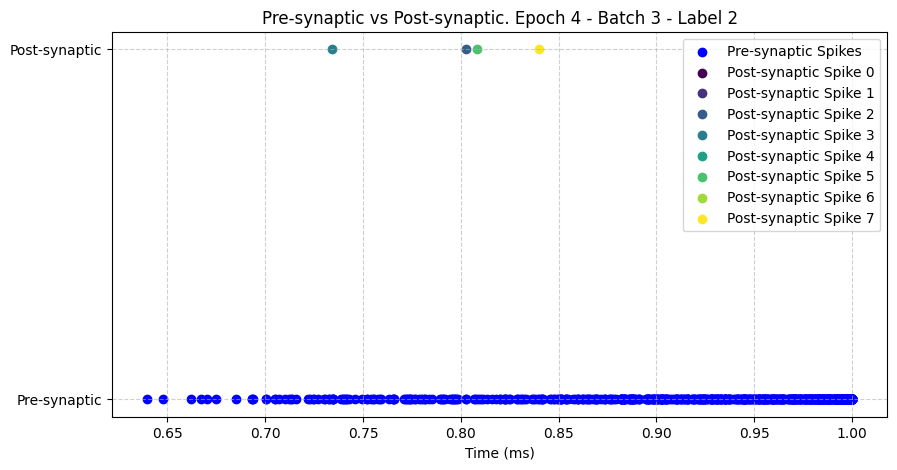

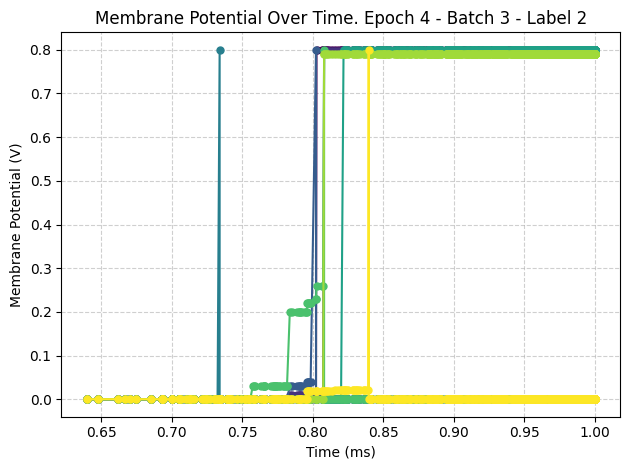

 58%|█████▊    | 7/12 [02:06<01:33, 18.61s/it]

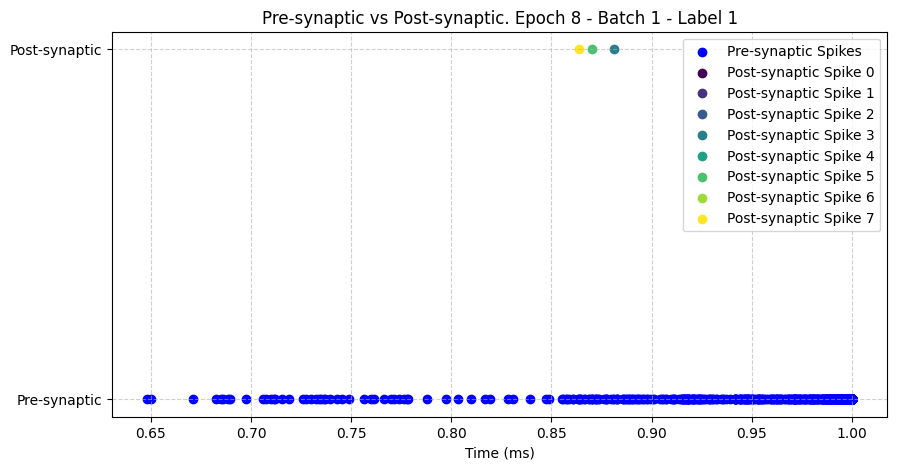

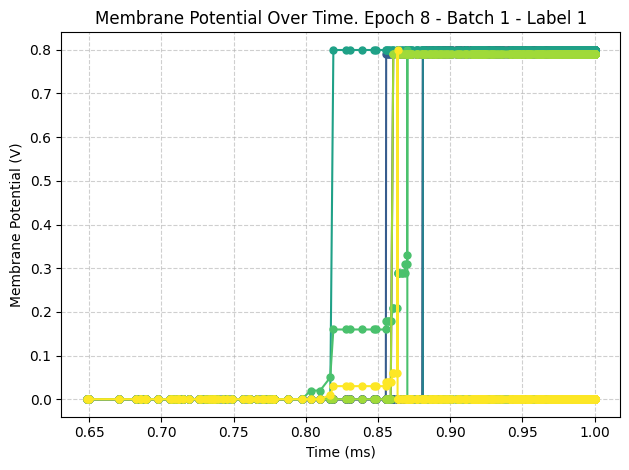

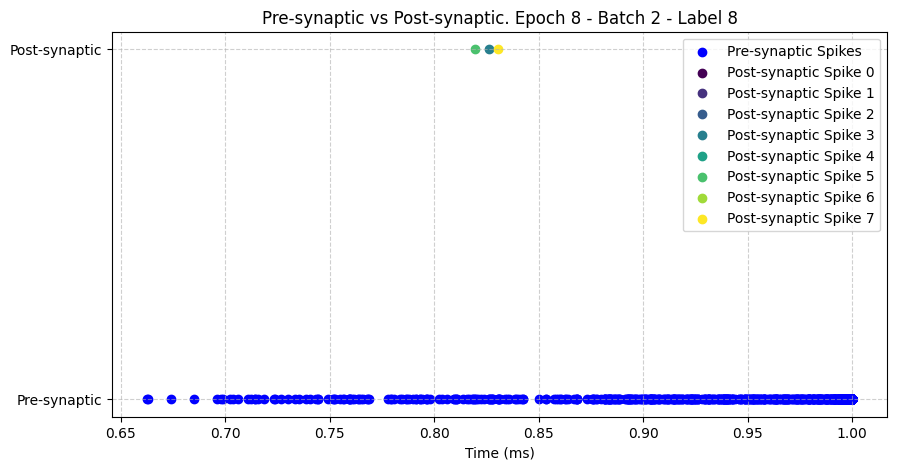

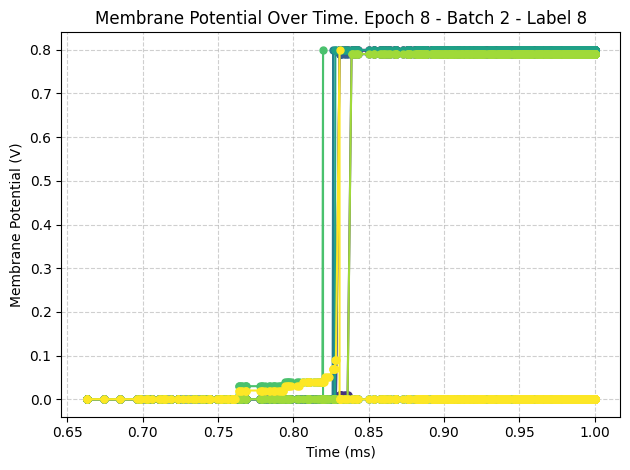

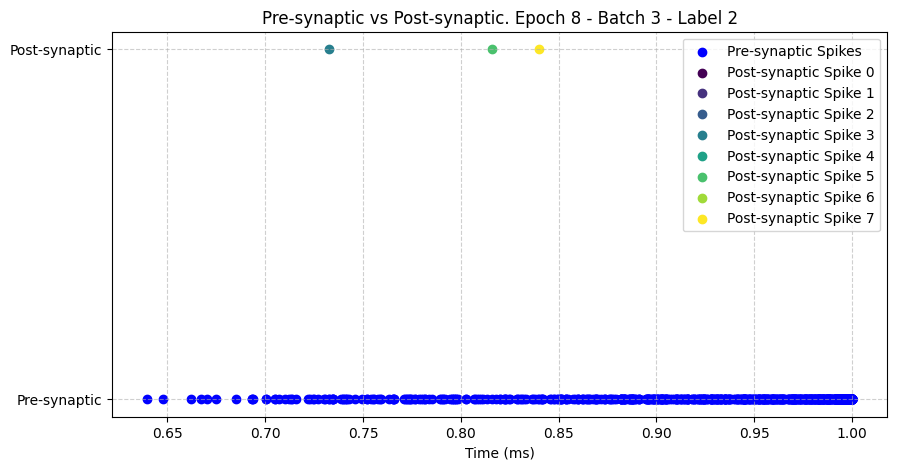

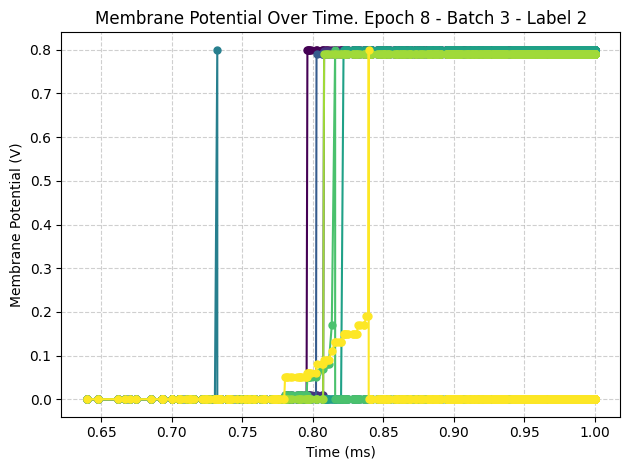

 92%|█████████▏| 11/12 [03:23<00:19, 19.20s/it]

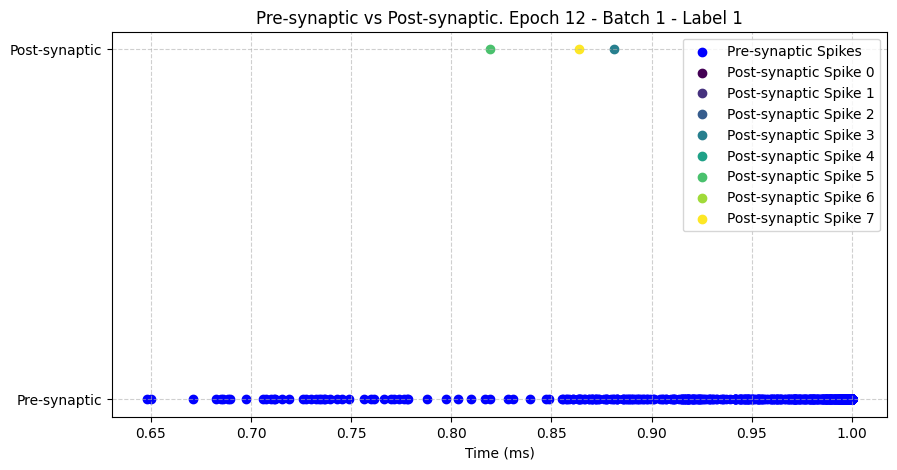

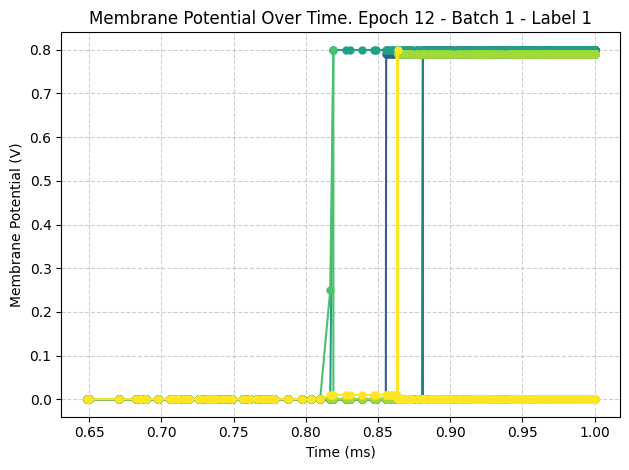

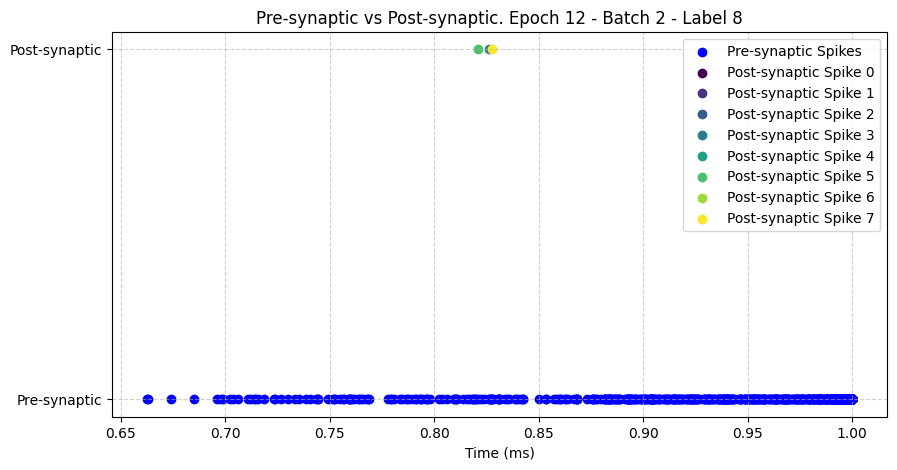

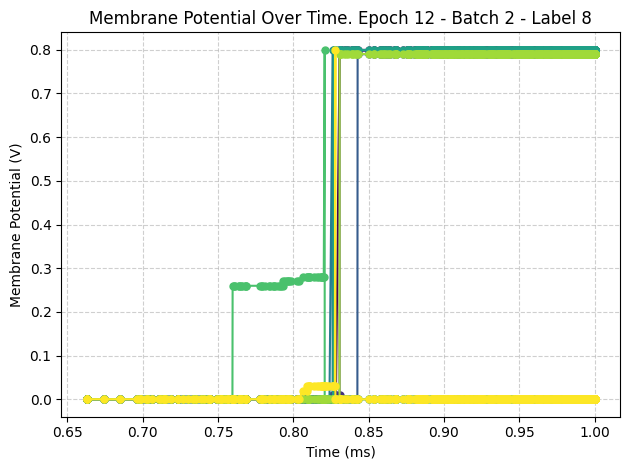

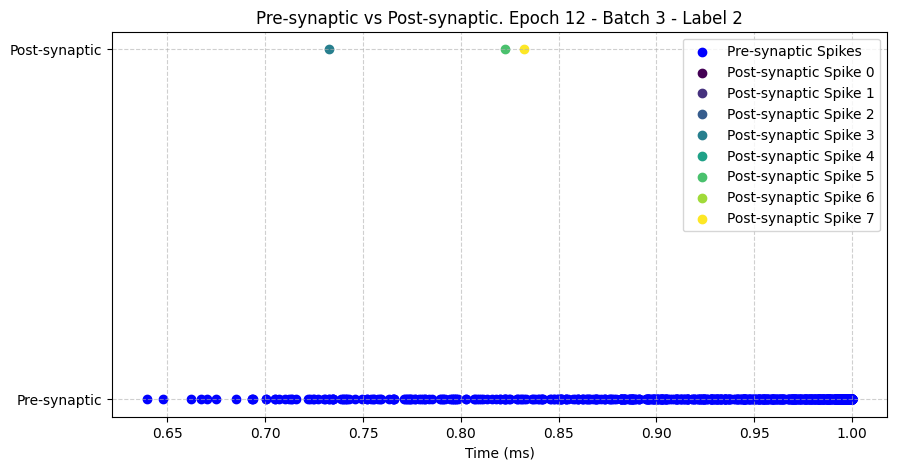

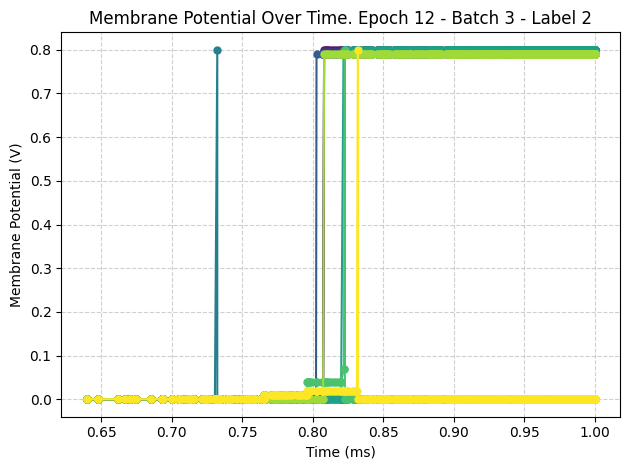

100%|██████████| 12/12 [03:43<00:00, 18.62s/it]


In [28]:
train(model3, num_epochs=12)

X_train.shape = (600, 8), y_train.shape = (600,)
X_test.shape = (100, 8), y_test.shape = (100,)
Train accuracy: 0.255


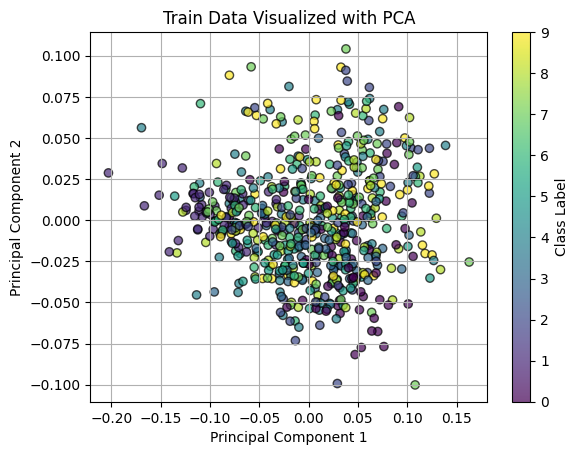

Accuracy: 0.23
Precision: 0.17
Recall: 0.23
F1 Score: 0.15
Confusion Matrix:
[[7 2 0 0 1 0 0 0 0 0]
 [0 9 0 0 0 0 0 0 0 1]
 [3 4 1 0 0 0 0 0 0 2]
 [9 0 1 0 0 0 0 0 0 0]
 [0 4 0 3 2 0 0 0 0 1]
 [4 2 1 1 0 0 0 0 0 2]
 [3 5 0 0 1 0 0 0 0 1]
 [4 2 0 0 1 0 0 1 0 2]
 [4 0 0 2 2 0 0 0 0 2]
 [1 4 1 0 0 0 0 1 0 3]]


/Users/Razvan/Uni/dummy-snn/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [34]:
eval_snn(model3)

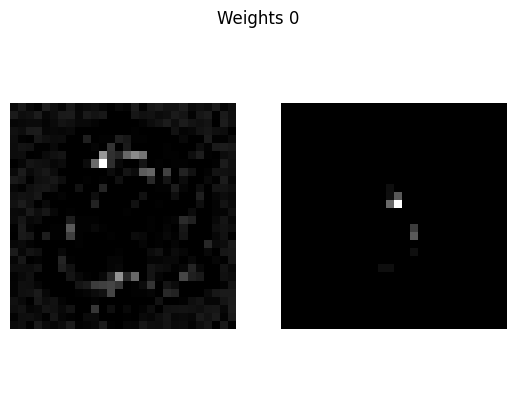

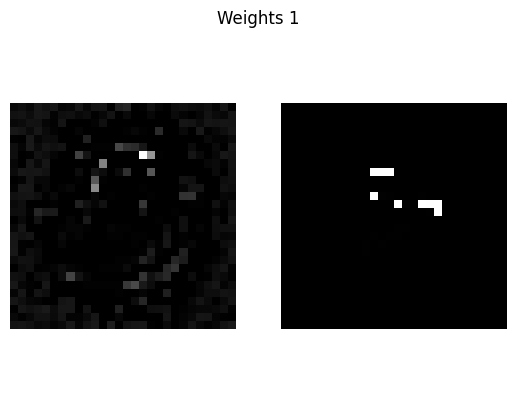

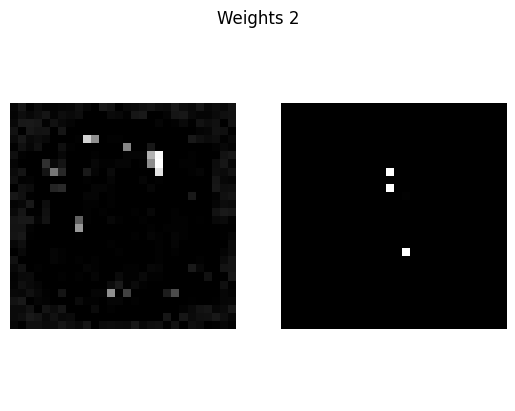

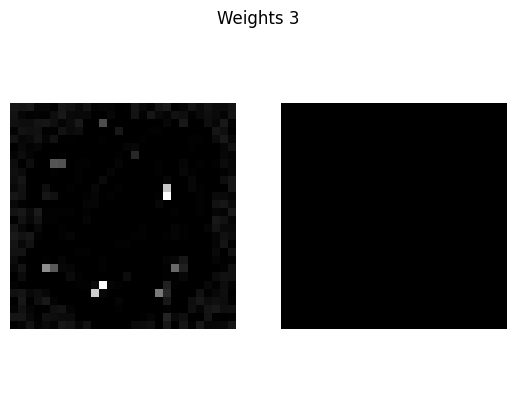

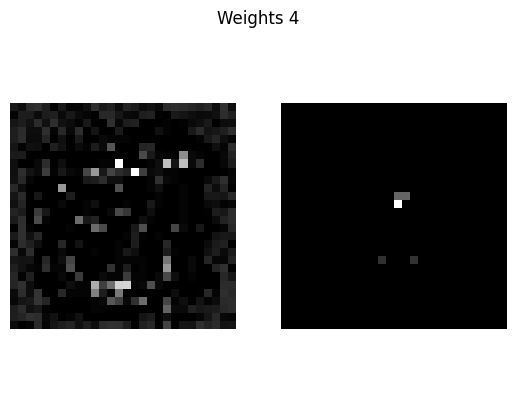

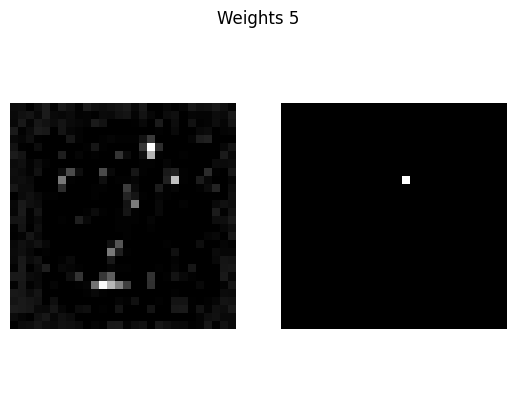

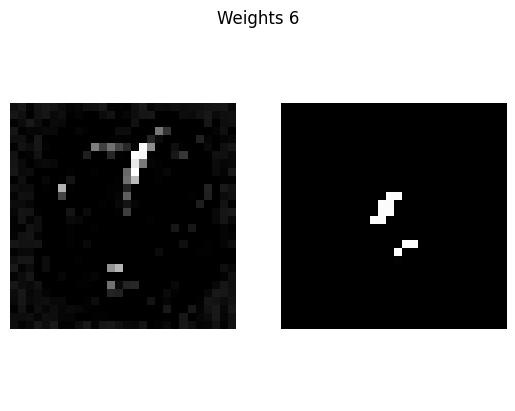

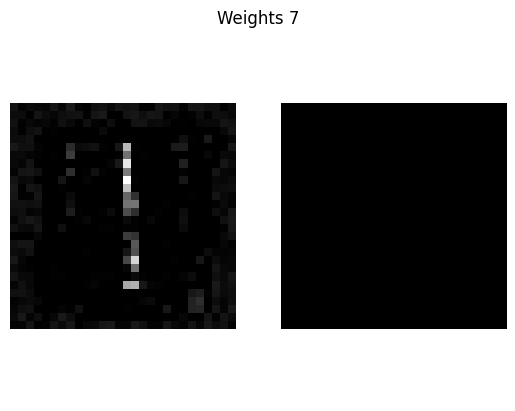

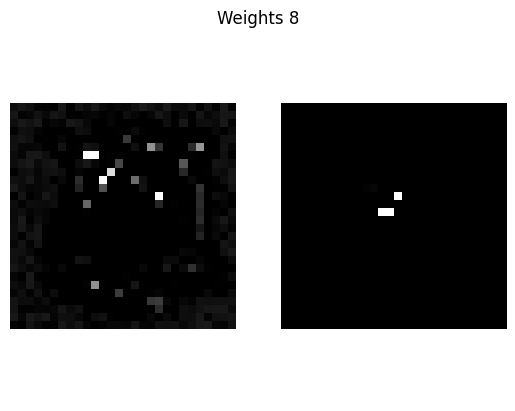

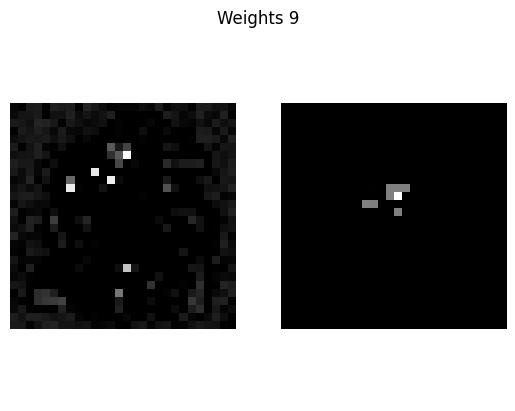

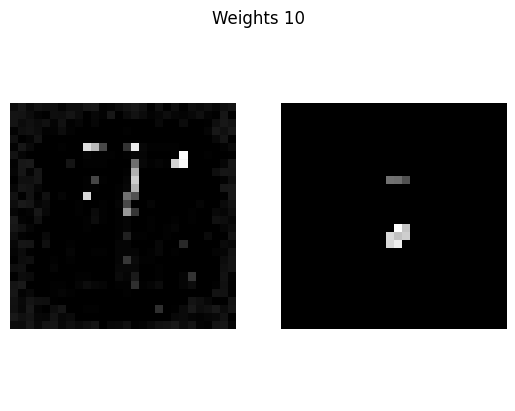

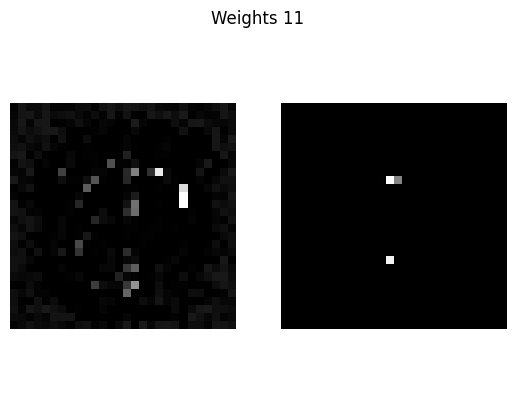

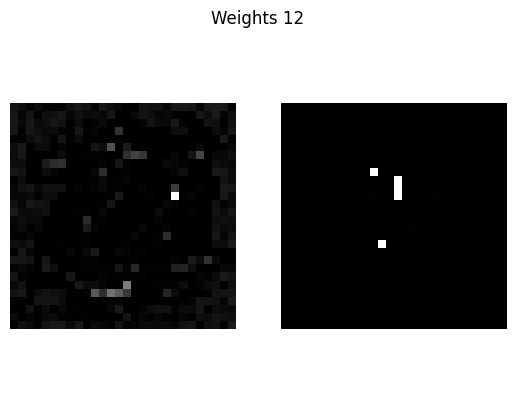

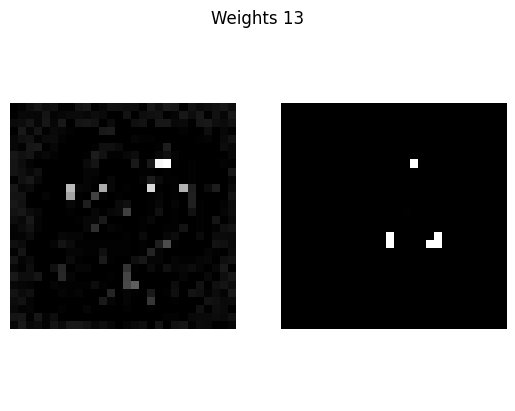

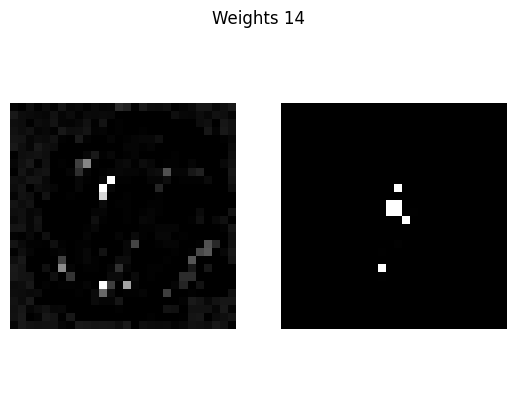

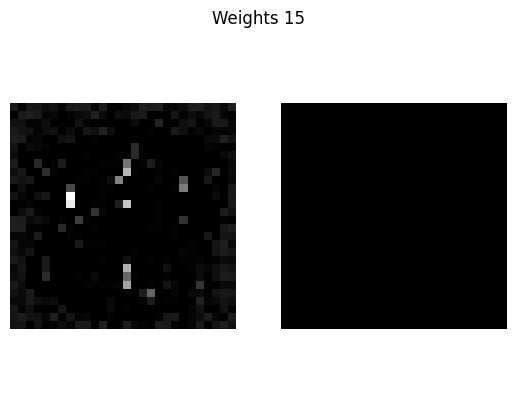

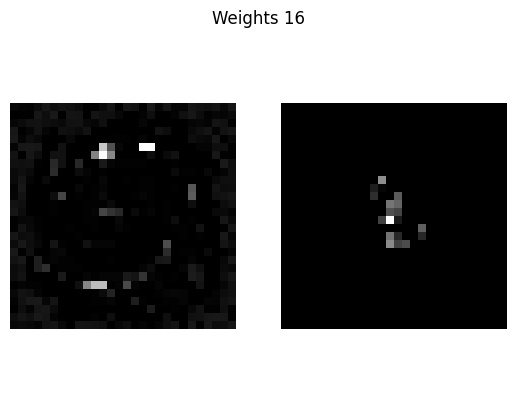

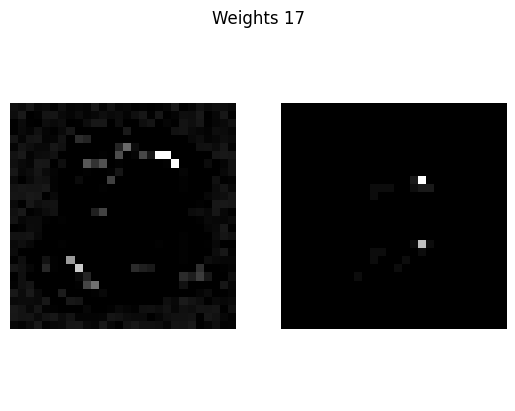

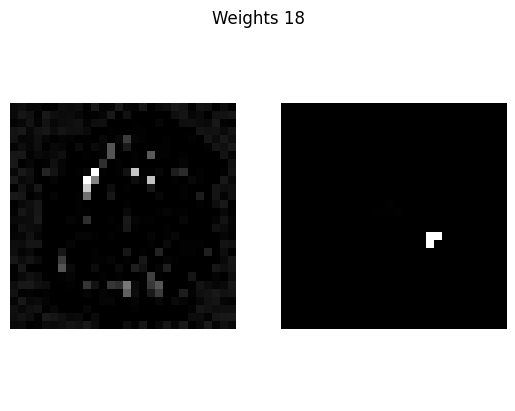

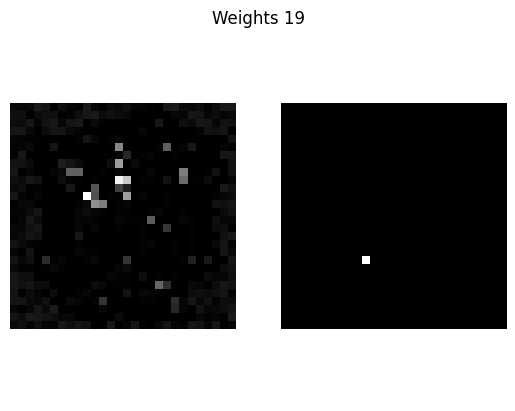

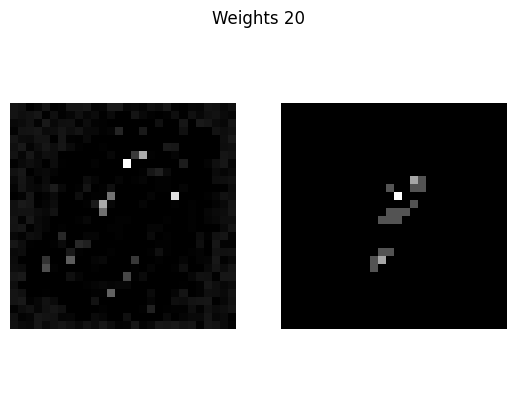

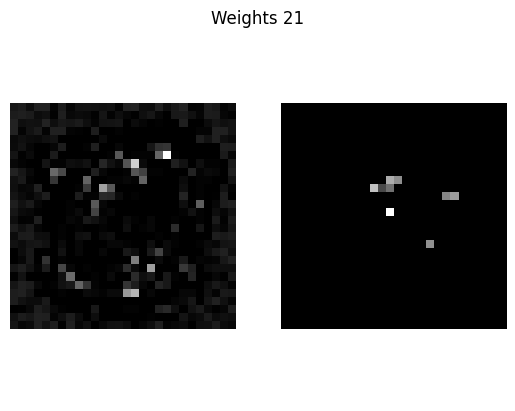

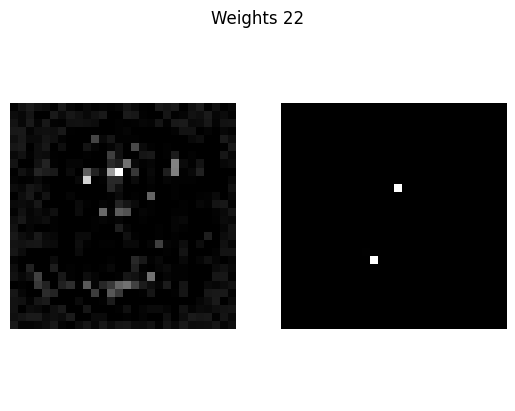

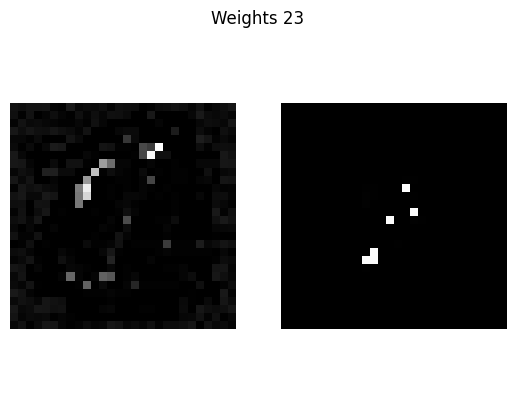

In [35]:
visualize_neurons_weights(model3, 0, 24)